In [1]:
import os
import pandas as pd
import geopandas as gpd
from pathlib import Path
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

from concorde.plots import scatter_interpolate
from concorde.tools import curvature
# from kalpana.export import pointsInsidePoly
import warnings
warnings.filterwarnings("ignore")
from shapely.geometry import Polygon, Point, LineString
import dask
from tqdm.dask import TqdmCallback
import itertools

#plt.style.use('dark_background')
# plt.style.use('tableau-colorblind10')

colors = plt.rcParams['axes.prop_cycle']
plt.rcParams.update({'font.size': 12})
from matplotlib.offsetbox import AnchoredText
from pyproj import Geod
pd.set_option('display.max_rows', 100)
import numpy as np

import matplotlib.patches as mpatches

import geopy.distance

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import itertools
from matplotlib import colors

from matplotlib.lines import Line2D
import string

In this version of the notebook I'm not using the 6deg circle nor the measure of the distance to NC to select storms

Notebook 000_* is not needed for the second batch, I did the entire process on this one.

In [2]:
nb = os.path.basename(globals()['__vsc_ipynb_file__'])[:-6]
nb

'001_STORM_select_data_for_mda_v4_batch02'

In [3]:
def plotTrack(_df, _tc):
    nc = Point((-76.8, 35.2))
    box = gpd.GeoDataFrame(geometry = [nc.buffer(6)])

    fig, ax = plt.subplots(figsize = (8, 8), subplot_kw={'projection': ccrs.PlateCarree()}, constrained_layout=True)
    dfsub = _df[_df['tc_number'] == _tc]
    dfsub.plot.scatter(x = 'lon', y = 'lat', ax = ax)
    gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=0.5, linestyle='--') # show coordinates and grig
    gl.top_labels = False
    gl.right_labels = False
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.COASTLINE,lw=0.25)
    ax.add_feature(cfeature.LAKES)
    box.boundary.plot(ax = ax)

    return ax

### Read storms and compute some parameters

In [6]:
pathin = Path(r'../data/STORM/raw/STORM_data')
filesIn = sorted([x for x in os.listdir(pathin) if '_NA_' in x])
columns = ['year', 'month', 'yr_tc_number', 'time_step', 'basin_id', 'lat', 'lon', 'min_press',
          'max_ws', 'rad_to_max_ws', 'cat', 'landfall', 'dist_to_land']

dfs = []
for ifile, file in enumerate(filesIn):
    print(file)
    df = pd.read_csv(pathin/file, header = None, names = columns)
    df['year'] = df['year'] + ifile * 1000
    dfs.append(df)
    
dfs = pd.concat(dfs, axis = 0)
dfs.index = range(len(dfs))

STORM_DATA_IBTRACS_NA_1000_YEARS_0.txt
STORM_DATA_IBTRACS_NA_1000_YEARS_1.txt
STORM_DATA_IBTRACS_NA_1000_YEARS_2.txt
STORM_DATA_IBTRACS_NA_1000_YEARS_3.txt
STORM_DATA_IBTRACS_NA_1000_YEARS_4.txt
STORM_DATA_IBTRACS_NA_1000_YEARS_5.txt
STORM_DATA_IBTRACS_NA_1000_YEARS_6.txt
STORM_DATA_IBTRACS_NA_1000_YEARS_7.txt
STORM_DATA_IBTRACS_NA_1000_YEARS_8.txt
STORM_DATA_IBTRACS_NA_1000_YEARS_9.txt


In [7]:
 ## change lon format from (0,360) to (-180, 180)
dfs['lon'] = np.mod(dfs['lon'].values - 180, 360.) - 180

In [8]:
## tc_number respect full dataset
index_start = np.where(dfs.time_step == 0)[0]
list0 = []
count = 0
for i, j in zip(index_start[:-1], index_start[1:]):
    list0.extend([count] * (j - i))
    count += 1
list0.extend([count] * (len(dfs) - j))
dfs['tc_number'] = list0

In [11]:
list_ls = []
for tc in dfs['tc_number'].unique():
    dfsub = dfs[dfs['tc_number'] == tc]
    ls = LineString(list(zip(dfsub['lon'], dfsub['lat'])))
    list_ls.append(ls)

gdfTracksAll = gpd.GeoDataFrame(geometry = list_ls, crs = 4326)
gdfTracksAll['tc_number'] = dfs['tc_number'].unique()
# gdfTracksAll.to_file(r'../gis/gpkg/STORM_NA_All.gpkg')

In [12]:
def stormDir(df):
    ''' direction going to as currents
    '''
    x = (df.loc[:, 'lon'].shift(-1) - df.loc[:, 'lon']).values
    y = (df.loc[:, 'lat'].shift(-1) - df.loc[:, 'lat']).values
    d = np.arctan2(x, y)
    d2 = np.rad2deg(d)
    d2 = np.mod(d2, 360)

    return d2

In [13]:
@dask.delayed
def stormDirAll(df, i):
    dfsub = df[df['tc_number'] == i]
    d = stormDir(dfsub)
    return d

tasks = [stormDirAll(dfs, i) for i in dfs['tc_number'].unique()]
# tasks = [get_trajectory(df, i) for i in [88467]]#df.tc_number.unique()]

with TqdmCallback(desc = "Computing distance"):
    aux = dask.compute(tasks, scheduler = 'threads')
    
auxM = list(itertools.chain(*aux))
auxM = list(itertools.chain(*auxM))

dfs['headingDir'] = auxM
dfs = dfs.fillna(method = 'ffill')

Computing distance: 100%|██████████| 109479/109479 [01:57<00:00, 930.29it/s]


In [14]:
def forwardSpeed(df):
    '''
    '''
    vellist = [np.nan] 
    for i, j in zip(df.index[:-1], df.index[1:]):
        p1 = (df.loc[i, 'lat'], df.loc[i, 'lon'])
        p2 = (df.loc[j, 'lat'], df.loc[j, 'lon'])
        dist = geopy.distance.geodesic(p2, p1).km
        vel = dist/3 ##km/hr, time step is 3hr
        vellist.append(vel)
    
    return vellist

In [15]:
@dask.delayed
def forwardSpeedAll(df, i):
    dfsub = df[df.tc_number == i]
    vel = forwardSpeed(dfsub)
    return vel

tasks = [forwardSpeedAll(dfs, i) for i in dfs['tc_number'].unique()]

with TqdmCallback(desc = "Computing distance"):
    aux = dask.compute(tasks, scheduler = 'threads')
    
auxM = list(itertools.chain(*aux))
auxM = list(itertools.chain(*auxM))

dfs['forwardSpeed'] = auxM
dfs = dfs.fillna(method = 'bfill')

Computing distance: 100%|██████████| 109479/109479 [08:46<00:00, 208.08it/s]


In [13]:
# ## distance to NC points from south to north
# ncs = [(-78, 33.9), (-76.5, 34.7), (-75.8, 35.4), (-75.9, 36.5)]

# @dask.delayed
# def dist2NC(y, x, pnt):
#     return geopy.distance.geodesic(pnt, (y, x)).km

# for inc, nc in enumerate(ncs):

#     tasks = [dist2NC(lat, lon, nc[::-1]) for lat, lon in zip(dfs['lat'], dfs['lon'])]

#     with TqdmCallback(desc = "Computing distance"):
#         d = dask.compute(tasks, scheduler = 'threads')

#     dfs[f'dist_to_NC{inc}'] = d[0]

# dfs.to_pickle(r'/mnt/drive1/Insyncs/NCSU/thesis/data/STORM/processed/STORM_NA_R5.pkl')

Computing distance: 100%|██████████| 3507558/3507558 [1:02:01<00:00, 942.39it/s] 


### Select new set of storms

In [4]:
dfs = pd.read_pickle(r'../data/STORM/processed/batch02/STORM_NA_R5_v1.pkl')
dfs.head()

year  month  yr_tc_number  time_step  basin_id  lat   lon   min_press  \
0   0.0   10.0           0.0        0.0       1.0  8.9 -45.2  993.946699   
1   0.0   10.0           0.0        1.0       1.0  9.0 -45.7  992.800000   
2   0.0   10.0           0.0        2.0       1.0  9.1 -46.4  992.100000   
3   0.0   10.0           0.0        3.0       1.0  9.2 -47.3  993.000000   
4   0.0   10.0           0.0        4.0       1.0  9.3 -48.3  993.100000   

      max_ws  rad_to_max_ws  cat  landfall  dist_to_land  tc_number  \
0  20.371998      46.299999  0.0       0.0    851.946656          0   
1  21.200000      45.905957  0.0       0.0    815.967429          0   
2  21.700000      45.511914  0.0       0.0    766.103506          0   
3  21.100000      45.117872  0.0       0.0    705.759651          0   
4  20.900000      44.723829  0.0       0.0    647.548285          0   

   headingDir  forwardSpeed  dist_to_NC0  dist_to_NC1  dist_to_NC2  \
0  281.309932     18.695934  4349.311963  4282.147509  4274.643957   
1  278.130102     18.695934  4302.369517  4236.397152  4229.733096   
2  276.340192     25.916882  4240.043560  4175.898126  4170.509432   
3  275.710593     33.179142  4162.703016  4101.066142  4097.414666   
4  281.309932     36.812210  4078.452652  4019.741347  4018.100153   

   dist_to_NC3  
0  4354.357649  
1  4310.241166  
2  4252.207304  
3  4180.705740  
4  4103.198492

##### Find storms inside the bathy defined polygon

In [5]:
mask = gpd.read_file(r'../gis/gpkg/polygon_coastline_NC.gpkg')

Find polygon with area of impact

In [6]:
def radImpact(vmax, rmax, vr = 33, beta = 1):
    r1 = rmax
    while True:
        r = rmax * (vr / vmax)**(-2 / beta) * (np.exp(1 - (rmax / r1)**beta))**(1 / beta)
        if np.abs(r - r1) < 1e-5:
            break
        r1 = r
    if r == 0:
        return rmax
    else:
        return r

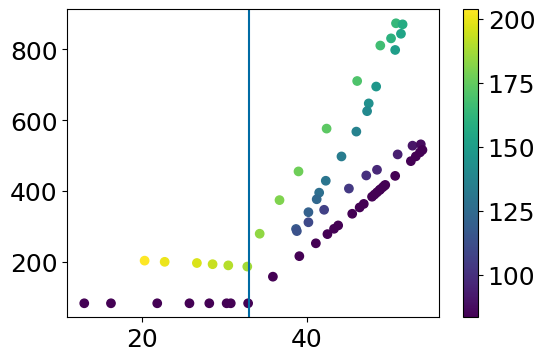

In [7]:
i = 31573
dftrack = dfs[dfs.tc_number == i]
ri = [radImpact(dftrack.loc[i, 'max_ws'], dftrack.loc[i, 'rad_to_max_ws']) for i in dftrack.index]

fig, ax = plt.subplots(figsize = (6,4))
sc = ax.scatter(dftrack['max_ws'].values, ri, c = dftrack['rad_to_max_ws'])
ax.axvline(x = 33)
fig.colorbar(sc)

In [8]:
# # I ran this in a separate python script outside vs code
# @dask.delayed
# def radImpactAll(df, i):
#     dftrack = df[df.tc_number == i]
#     ri = [radImpact(dftrack.loc[i, 'max_ws'], dftrack.loc[i, 'rad_to_max_ws']) for i in dftrack.index]
#     pols = []
#     for i, r in zip(dftrack.index, ri):
#         pnt = Point((dftrack.loc[i, 'lon'], dftrack.loc[i, 'lat']))
#         pol = pnt.buffer(r/110)
#         pols.append(pol)
#     gdfPol = gpd.GeoDataFrame(geometry=pols, crs = 4326)
#     gdfPol2 = gpd.GeoDataFrame(geometry = [gdfPol.unary_union], crs = 4326)
    
#     return gdfPol2

# tasks = [radImpactAll(dfs, i) for i in dfs['tc_number'].unique()[:10]]

# with TqdmCallback(desc = "Computing distance"):
#     aux = dask.compute(tasks, scheduler = 'threads')

# gdfAoi = pd.concat(aux[0])
# gdfAoi.to_file(r'../data/STORM/processed/STORM_NA_R5_area_of_impact.gpkg')

In [8]:
gdfAoi = gpd.read_file(r'../data/STORM/processed/batch02/STORM_NA_R5_area_of_impact.gpkg')

In [9]:
indexIn, indexOut = [], []
for i in tqdm(gdfAoi.index):
    maskPol = mask.geometry.iloc[0]
    aoi = gdfAoi.iloc[[i]].geometry.iloc[0]
    b = maskPol.intersects(aoi)
    if b == True:
        indexIn.append(i)
    else:
        indexOut.append(i)

100%|██████████| 109479/109479 [01:54<00:00, 957.72it/s]


In [12]:
len(indexIn)

3626

<GeoAxesSubplot: xlabel='lon', ylabel='lat'>

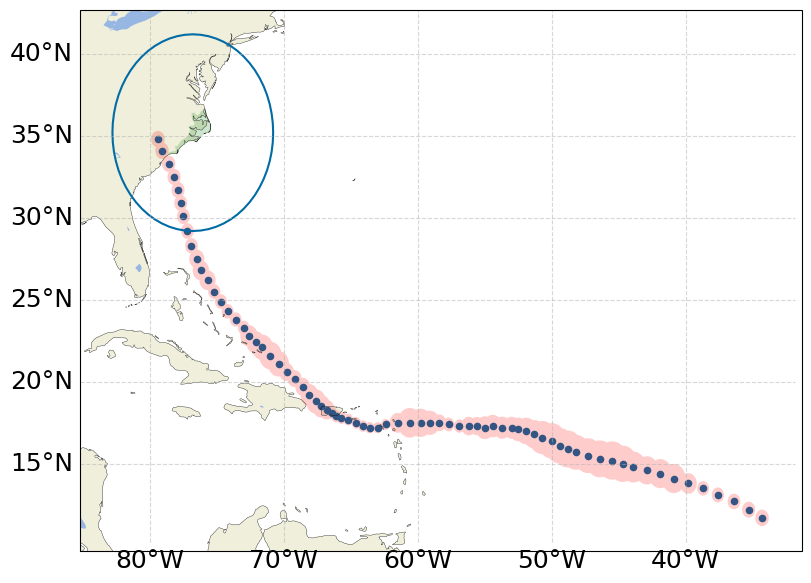

In [31]:
ax = plotTrack(dfs, 33)
gdfAoi.iloc[[33]].plot(ax = ax, alpha = 0.2, color = 'r')
mask.plot(ax = ax, alpha = 0.2, color = 'g')
# ax.set_xlim([-78, -77])
# ax.set_ylim([34, 35])

In [14]:
dfsIn = dfs.loc[dfs['tc_number'].isin(indexIn), :]

In [15]:
dfsIn.to_pickle(r'../data/STORM/processed/batch02/STORM_NA_R5_In_v3.pkl')

In [16]:
dfsIn.head()

year  month  yr_tc_number  time_step  basin_id   lat   lon   min_press  \
885   3.0    9.0           1.0        0.0       1.0  11.7 -34.3  995.983156   
886   3.0    9.0           1.0        1.0       1.0  12.2 -35.3  995.300000   
887   3.0    9.0           1.0        2.0       1.0  12.7 -36.4  992.500000   
888   3.0    9.0           1.0        3.0       1.0  13.1 -37.6  986.700000   
889   3.0    9.0           1.0        4.0       1.0  13.5 -38.7  980.100000   

        max_ws  rad_to_max_ws  cat  landfall  dist_to_land  tc_number  \
885  18.108442      55.560001  0.0       0.0   1115.458378         33   
886  18.600000      53.823751  0.0       0.0   1206.865326         33   
887  20.900000      52.087501  0.0       0.0   1314.642223         33   
888  25.000000      50.351251  0.0       0.0   1428.717969         33   
889  29.500000      48.615001  1.0       0.0   1533.428814         33   

     headingDir  forwardSpeed  dist_to_NC0  dist_to_NC1  dist_to_NC2  \
885  296.565051     40.720393  5062.697803  4961.867930  4930.108069   
886  294.443955     40.720393  4942.191613  4841.994703  4810.771167   
887  288.434949     43.920758  4813.089562  4713.734128  4683.208696   
888  289.983107     45.848683  4682.025698  4584.009576  4554.553492   
889  285.255119     42.379373  4559.923724  4463.085549  4434.574919   

     dist_to_NC3  
885  4984.444691  
886  4865.789977  
887  4739.097585  
888  4611.728405  
889  4492.883491

In [17]:
@dask.delayed
def intersectPnts(df, i):
    dftrack = df[df['tc_number'] == i]
    radii = [radImpact(dftrack.loc[i, 'max_ws'], dftrack.loc[i, 'rad_to_max_ws']) for i in dftrack.index]
    pols = []
    for it, ri in zip(dftrack.index, radii):
        pnt = Point((dftrack.loc[it, 'lon'], dftrack.loc[it, 'lat']))
        pol = pnt.buffer(ri/110)

        if maskPol.intersects(pol):
            pols.append(pnt)

    if len(pols) == 1:
        ls = pols[0]

    else:
        ls = LineString(pols)
        
    return ls, i

tasks = [intersectPnts(dfsIn, i) for i in dfsIn['tc_number'].unique()]

with TqdmCallback(desc = "Computing distance"):
    aux = dask.compute(tasks, scheduler = 'threads')

uz1, uz2 = zip(*aux[0])
gdfInter = gpd.GeoDataFrame(geometry = gpd.GeoSeries(uz1), crs = 4326)
gdfInter['tc_number'] = uz2

Computing distance: 100%|██████████| 3626/3626 [00:48<00:00, 75.15it/s] 


In [19]:
def find_longest_consecutive(numbers):
    longest_sequence = []
    current_sequence = []
    
    for num in numbers:
        if not current_sequence or num == current_sequence[-1] + 1:
            current_sequence.append(num)
        else:
            if len(current_sequence) > len(longest_sequence):
                longest_sequence = current_sequence
            current_sequence = [num]
    
    if len(current_sequence) > len(longest_sequence):
        longest_sequence = current_sequence
    
    return longest_sequence

In [32]:
meanHeadingDir = []
meanCurvature = []

newDfs = []

for itc, tc in tqdm(enumerate(dfsIn['tc_number'].unique())):
    dfSub = dfsIn[dfsIn['tc_number'] == tc]
    inter = gdfInter[gdfInter['tc_number'] == tc]

    coordsTrack = list(zip(dfSub['lon'], dfSub['lat']))
    coordsInter = list(inter.iloc[0].geometry.coords)
    inds = [coordsTrack.index(x) for x in coordsInter]
    longest_sequence = find_longest_consecutive(inds)

    dfSubInter = dfSub.iloc[longest_sequence, :]

    xs = [np.cos(np.deg2rad(a)) for a in dfSubInter.loc[:, 'headingDir']]
    ys = [np.sin(np.deg2rad(a)) for a in dfSubInter.loc[:, 'headingDir']]
    mHeadD = np.mod(np.rad2deg(np.arctan2(np.mean(ys), np.mean(xs))), 360)
    
    meanHeadingDir.append(mHeadD)

    if len(dfSubInter) > 1:
        cur = curvature(dfSubInter['lon'].values, dfSubInter['lat'].values)
        meanCurvature.append(np.nanmean(cur))
    else:
        meanCurvature.append(0)

    dfSub['windIntersectNC'] = [0] * len(dfSub)
    dfSub.iloc[inds, -1] = [1]*len(inds)
    newDfs.append(dfSub)

dfsInNew = pd.concat(newDfs)

0it [00:00, ?it/s]

3626it [00:10, 333.66it/s]


In [34]:
dfsInNew.to_pickle(r'../data/STORM/processed/batch02/STORM_NA_R5_In_inter_v3.pkl')

In [25]:
@dask.delayed
def track2point(df, i):
    dfsub = df[(df.tc_number == i)]
    ## fill na values of trajectory
    dfsub = dfsub.fillna(method = 'ffill')
    indMinPress = dfsub['min_press'].idxmin()
    indMinDist = dfsub[[x for x in dfsub.columns if x.startswith('dist_to_NC')]].min(axis = 1).idxmin()
        
    l = [float(dfsub.year.unique()), #year
         float(dfsub.month.unique()), #month
         float(dfsub.yr_tc_number.unique()), #yearly tc number 
         dfsub.loc[indMinPress, 'time_step'], #ts min press
         dfsub.loc[indMinDist, 'time_step'], #ts min dist
         dfsub.loc[indMinPress, 'lat'], #lat min press
         dfsub.loc[indMinPress, 'lon'], # lon min press
         dfsub.loc[indMinDist, 'lat'], #lat min dist
         dfsub.loc[indMinDist, 'lon'], #lon min dist
         dfsub.loc[indMinDist, 'min_press'], #min press at min dist
         dfsub.loc[indMinPress, 'min_press'], #min press at min press
         dfsub.loc[indMinDist, 'max_ws'], #max ws at min dist
         dfsub.loc[indMinPress, 'max_ws'], #max ws at min press
         dfsub.loc[indMinDist, 'rad_to_max_ws'], #max rmw at min dist
         dfsub.loc[indMinPress, 'rad_to_max_ws'], #max rmw at min press
         dfsub.loc[indMinDist, 'forwardSpeed'], #f speed at min dist
         dfsub.loc[indMinPress, 'forwardSpeed'], #f speed at min press
         float(dfsub.cat.max()), #max category
         float(dfsub.landfall.max()),  #categorical landfall
         float(dfsub.tc_number.unique()), #tc number
         dfsub[[x for x in dfsub.columns if x.startswith('dist_to_NC')]].min(axis = 1).min(), #min dist to NC
         dfsub.loc[indMinPress, [x for x in dfsub.columns if x.startswith('dist_to_NC')]].min(), #dist NC at min press
         dfsub.loc[indMinDist, 'headingDir'], #trajectory at min dist
         dfsub.loc[indMinPress, 'headingDir'], #trajectory at min press
         len(dfsub)*3, ## from number of timesteps to hours
         dfsub.loc[dfsub.index[0], 'lat'], #lat gen
         dfsub.loc[dfsub.index[0], 'lon']] #lon gen
    return l

tasks = [track2point(dfsIn, i) for i in dfsIn['tc_number'].unique()]
with TqdmCallback(desc = "Track 2 point"):
    aux = dask.compute(tasks, scheduler = 'threads')

Track 2 point: 100%|██████████| 3626/3626 [00:09<00:00, 374.06it/s]


In [26]:
auxMerged = list(itertools.chain(*aux))
dfpnt = pd.DataFrame(auxMerged,
                     columns = ['year', 
                                'month', 
                                'yr_tc_number', 
                                'time_step_at_min_press', 
                                'time_step_at_min_distNC',
                                'lat_at_min_press', 
                                'lon_at_min_press', 
                                'lat_at_min_distNC', 
                                'lon_at_min_distNC',
                                'min_press_at_min_distNC', 
                                'min_press_at_min_press',
                                'max_ws_at_min_distNC', 
                                'max_ws_at_min_press',
                                'rad_to_max_ws_at_min_distNC', 
                                'rad_to_max_ws_at_min_press',
                                'forward_speed_at_min_distNC', 
                                'forward_speed_at_min_press',
                                'max_cat', 
                                'landfall', 
                                'tc_number', 
                                'distNC_at_min_distNC', 
                                'distNC_at_min_press',
                                'heading_dir_at_min_distNC', 
                                'heading_dir_at_min_press', 
                                'duration', 
                                'lat_gen', 
                                'lon_gen'])

In [27]:
geod = Geod(ellps="WGS84")
dfpnt['length'] = [geod.geometry_length(LineString(list(zip(dfsIn[dfsIn['tc_number'] == i]['lon'], 
                                          dfsIn[dfsIn['tc_number'] == i]['lat'])))) for i in dfsIn['tc_number'].unique()]

In [28]:
dfpnt['mean_heading_dir_inter'] = meanHeadingDir
dfpnt['mean_curvature_inter'] = meanCurvature

In [29]:
dfpnt.to_pickle(r"../data/STORM/processed/batch02/STORM_NA_R5_In_v3_pnt.pkl")


#### Plots

In [2]:
dftracksFull = pd.read_pickle(r"../data/STORM/processed/batch02/STORM_NA_R5_In_v3.pkl")
dftracks = pd.read_pickle(r"../data/STORM/processed/batch02/STORM_NA_R5_In_sortedMDA_shortened_dates_v3.pkl")
dfaoi = gpd.read_file(r'../data/STORM/processed/batch02/STORM_NA_R5_area_of_impact.gpkg')
mask = gpd.read_file(r'../gis/gpkg/polygon_coastline_NC.gpkg')

In [3]:
dfs = pd.read_pickle(r'../data/STORM/processed/batch02/STORM_NA_R5_v1.pkl')

In [4]:
cmap = plt.cm.viridis

In [5]:
# tracks, max_cat = [], []
# for tc in dfs['tc_number'].unique():
#     storm = dfs[dfs['tc_number'] == tc]
#     gdf_track = gpd.GeoDataFrame(geometry = [LineString(list(zip(storm['lon'], storm['lat'])))], crs = 4326)
#     tracks.append(gdf_track)
#     max_cat.append(storm['cat'].max())
# gdftracks = pd.concat(tracks, axis = 0)
# gdftracks['max_cat'] = max_cat
# gdftracks.to_file(r'../gis/gpkg/STORM_NA_ALL.gpkg', driver = 'GPKG')

gdftracks = gpd.read_file(r'../gis/gpkg/STORM_NA_ALL.gpkg')

In [6]:
dfworld = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

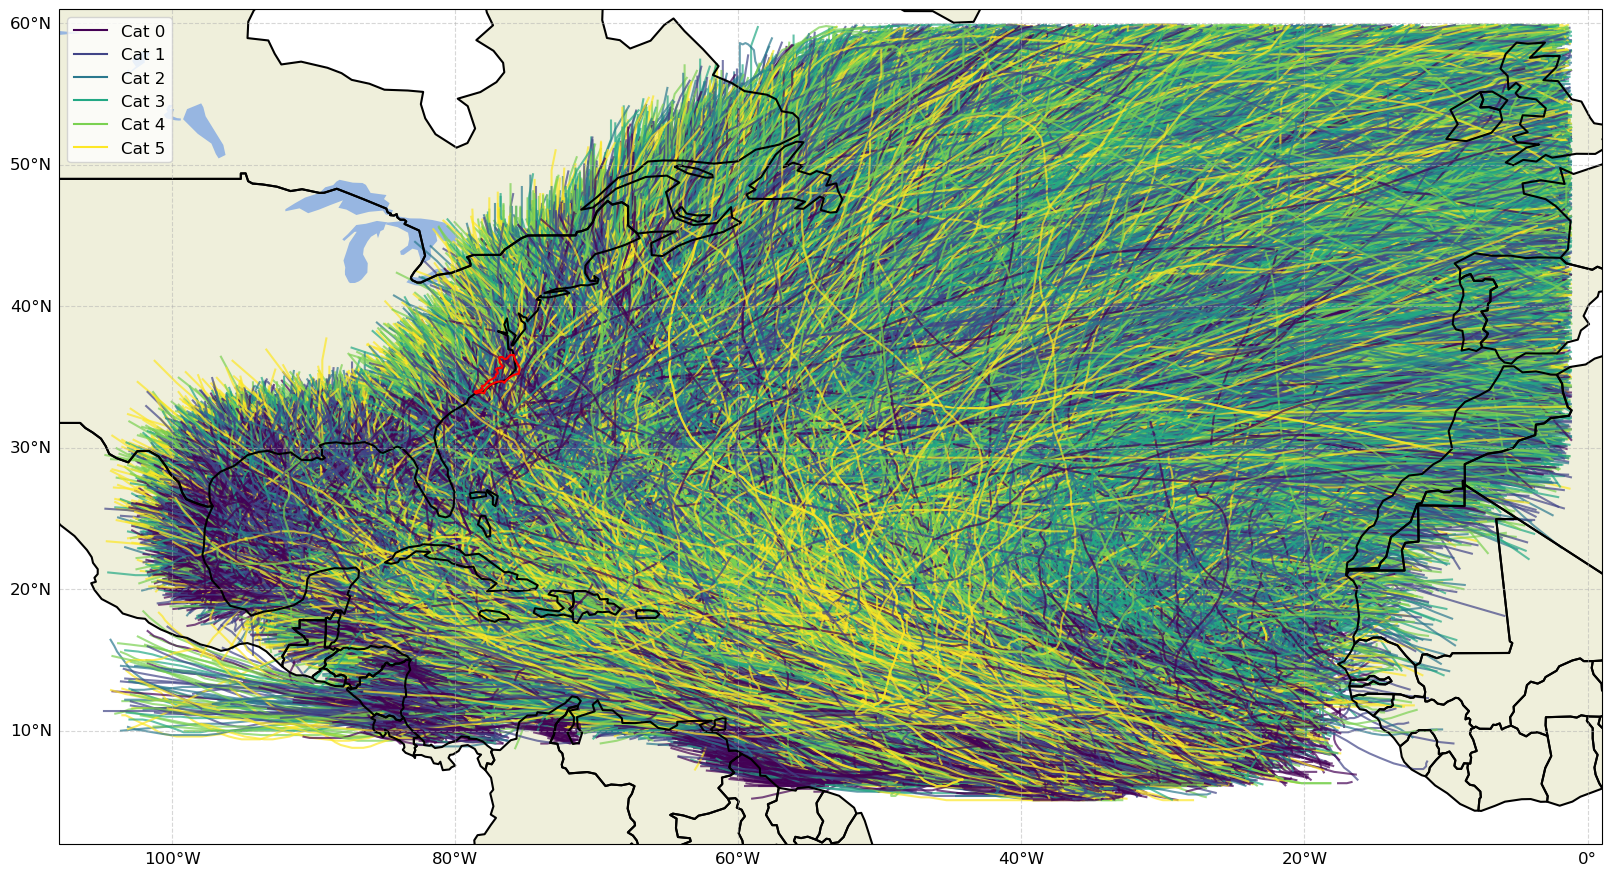

In [7]:
fig, ax = plt.subplots(figsize = (16, 9), subplot_kw={'projection': ccrs.PlateCarree()}, constrained_layout=True)
gdftracks.plot(ax = ax, alpha = 0.7, column = 'max_cat', cmap = 'viridis', legend = True, categorical = True)
dfworld.boundary.plot(ax = ax, color = 'k')
mask.boundary.plot(ax = ax, color = 'r')
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
ax.add_feature(cfeature.LAND)
# ax.add_feature(cfeature.COASTLINE,lw=10)
ax.add_feature(cfeature.LAKES)
ax.set_xlim([-108, 1])
ax.set_ylim([2, 61])
ax.set_aspect('equal')
ax.set_xlabel('Longitude [deg]')
ax.set_ylabel('Latitude [deg]')


legend_elements = [Line2D([0], [0], color=cmap(i/5), label = f'Cat {i}') for i in range(6)]
ax.legend(handles=legend_elements, loc = 'upper left')

# fig.savefig(r'../documents/waves_and_storm_surge/STORM_alltracks_NA.png', dpi = 300, bbox_inches = 'tight')
# fig.savefig(r'/home/tomas/Insync/tacuevas@ncsu.edu/Google Drive/NCSU/thesis/documents/adcircMeeting/STORM_alltracks_NA.png', dpi = 300, bbox_inches = 'tight')
fig.savefig(r'..//documents/thesis/STORM_alltracks_NA.png', dpi = 300, bbox_inches = 'tight')

In [ ]:
fig, ax = plt.subplots(figsize = (16, 9), subplot_kw={'projection': ccrs.PlateCarree()}, constrained_layout=True)
gdftracks.plot(ax = ax, alpha = 0.7, column = 'max_cat', cmap = 'viridis', legend = True, categorical = True)
dfworld.boundary.plot(ax = ax, color = 'k')
mask.boundary.plot(ax = ax, color = 'r')
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
ax.add_feature(cfeature.LAND)
# ax.add_feature(cfeature.COASTLINE,lw=10)
ax.add_feature(cfeature.LAKES)
ax.set_xlim([-108, 1])
ax.set_ylim([2, 61])
ax.set_aspect('equal')
ax.set_xlabel('Longitude [deg]')
ax.set_ylabel('Latitude [deg]')


legend_elements = [Line2D([0], [0], color=cmap(i/5), label = f'Cat {i}') for i in range(6)]
ax.legend(handles=legend_elements, loc = 'upper left')

# fig.savefig(r'../documents/waves_and_storm_surge/STORM_alltracks_NA.png', dpi = 300, bbox_inches = 'tight')
# fig.savefig(r'/home/tomas/Insync/tacuevas@ncsu.edu/Google Drive/NCSU/thesis/documents/adcircMeeting/STORM_alltracks_NA.png', dpi = 300, bbox_inches = 'tight')
fig.savefig(r'..//documents/thesis/STORM_alltracks_NA.png', dpi = 300, bbox_inches = 'tight')

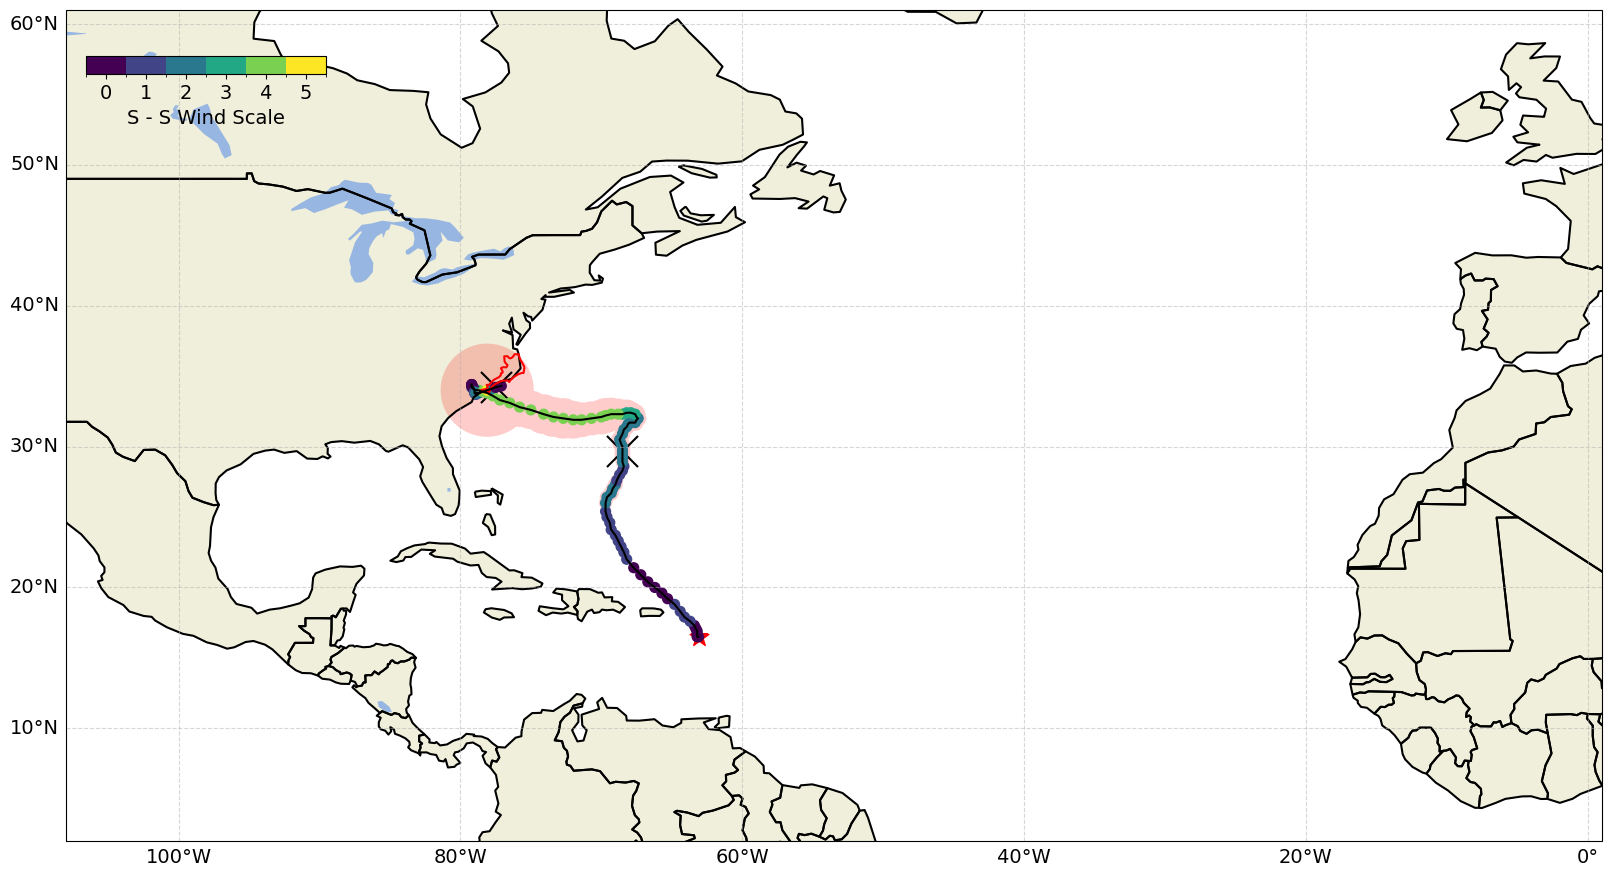

In [129]:
tc = 61112
storm = dftracksFull[dftracksFull['tc_number'] == tc]
stormShort = dftracks[dftracks['tc_number'] == tc]


fig, ax = plt.subplots(figsize = (16, 9), subplot_kw={'projection': ccrs.PlateCarree()}, constrained_layout=True)
dfworld.boundary.plot(ax = ax, color = 'k')
mask.boundary.plot(ax = ax, color = 'r')
ax.plot(storm['lon'], storm['lat'], color = 'k')

aoi = dfaoi.loc[[tc]]
norm = colors.BoundaryNorm(np.arange(0, 7, 1), cmap.N)

aoi.plot(ax = ax, color = 'r', alpha = 0.2)
ax.scatter(storm['lon'].iloc[0], storm['lat'].iloc[0], color = 'r', marker = '*', s = 200)
ax.scatter(stormShort['lon'].iloc[0], stormShort['lat'].iloc[0], color = 'k', marker = 'x', s = 500)
ax.scatter(stormShort['lon'].iloc[-1], stormShort['lat'].iloc[-1], color = 'k', marker = 'x', s = 500)
ax.scatter(storm['lon'], storm['lat'], c = storm['cat'], cmap = cmap, norm = norm, s = 50)

gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=0.5, linestyle='--') # show coordinates and grig
gl.top_labels = False
gl.right_labels = False
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE,lw=0.25)
ax.add_feature(cfeature.LAKES)
ax.set_xlim([-108, 1])
ax.set_ylim([2, 61])
ax.set_aspect('equal')
ax.set_xlabel('Longitude [deg]')
ax.set_ylabel('Latitude [deg]')

fig = ax.get_figure()
cax = fig.add_axes([0.05, 0.89, 0.15, 0.02])
sm = plt.cm.ScalarMappable(cmap = cmap, norm = norm)
sm._A = []
cb = fig.colorbar(sm, cax = cax, label = 'S - S Wind Scale', orientation = 'horizontal')
loc = np.arange(0, 6, 1) + .5
cb.set_ticks(loc)
cb.set_ticklabels(np.arange(0, 6, 1))

# fig.savefig(f'../documents/waves_and_storm_surge/track_storm_{tc}.png', dpi = 300, bbox_inches = 'tight')
# fig.savefig(f'../documents/thesis/track_storm_{tc}.png', dpi = 300, bbox_inches = 'tight')

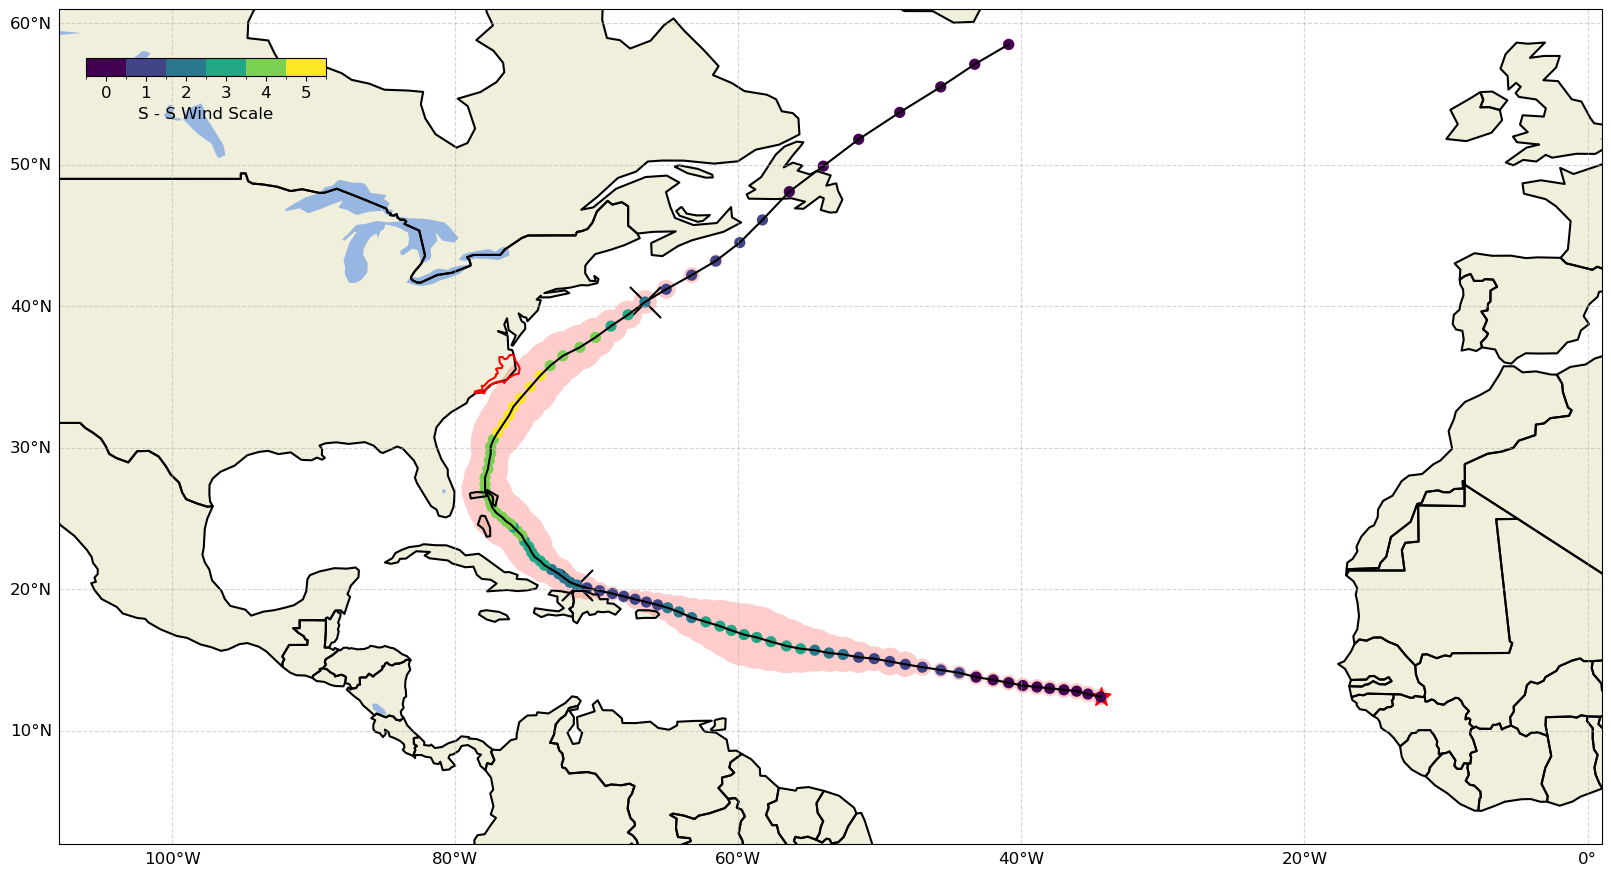

In [9]:
tc = 54331
storm = dftracksFull[dftracksFull['tc_number'] == tc]
stormShort = dftracks[dftracks['tc_number'] == tc]


fig, ax = plt.subplots(figsize = (16, 9), subplot_kw={'projection': ccrs.PlateCarree()}, constrained_layout=True)
dfworld.boundary.plot(ax = ax, color = 'k')
mask.boundary.plot(ax = ax, color = 'r')
ax.plot(storm['lon'], storm['lat'], color = 'k')

aoi = dfaoi.loc[[tc]]
norm = colors.BoundaryNorm(np.arange(0, 7, 1), cmap.N)

aoi.plot(ax = ax, color = 'r', alpha = 0.2)
ax.scatter(storm['lon'].iloc[0], storm['lat'].iloc[0], color = 'r', marker = '*', s = 200)
ax.scatter(stormShort['lon'].iloc[0], stormShort['lat'].iloc[0], color = 'k', marker = 'x', s = 500)
ax.scatter(stormShort['lon'].iloc[-1], stormShort['lat'].iloc[-1], color = 'k', marker = 'x', s = 500)
ax.scatter(storm['lon'], storm['lat'], c = storm['cat'], cmap = cmap, norm = norm, s = 50)


gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=0.5, linestyle='--') # show coordinates and grig
gl.top_labels = False
gl.right_labels = False
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE,lw=0.25)
ax.add_feature(cfeature.LAKES)
ax.set_xlim([-108, 1])
ax.set_ylim([2, 61])
ax.set_aspect('equal')
ax.set_xlabel('Longitude [deg]')
ax.set_ylabel('Latitude [deg]')

fig = ax.get_figure()
cax = fig.add_axes([0.05, 0.89, 0.15, 0.02])
sm = plt.cm.ScalarMappable(cmap = cmap, norm = norm)
sm._A = []
cb = fig.colorbar(sm, cax = cax, label = 'S - S Wind Scale', orientation = 'horizontal')
loc = np.arange(0, 6, 1) + .5
cb.set_ticks(loc)
cb.set_ticklabels(np.arange(0, 6, 1))

fig.savefig(f'../documents/thesis/track_storm_{tc}.png', dpi = 300, bbox_inches = 'tight')

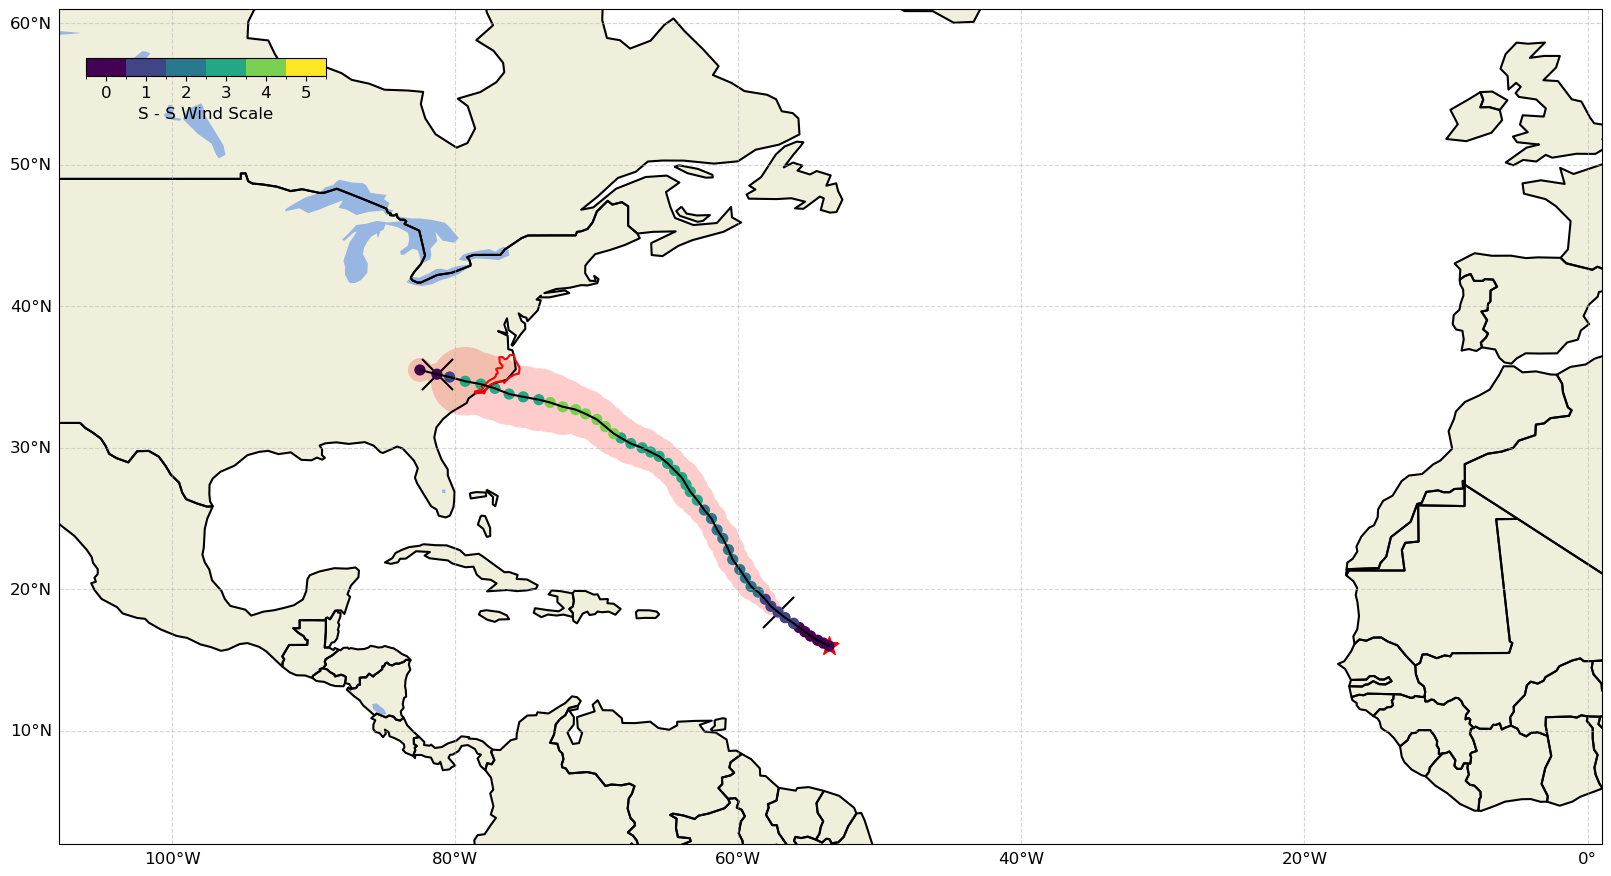

In [10]:
tc = 20688
storm = dftracksFull[dftracksFull['tc_number'] == tc]
stormShort = dftracks[dftracks['tc_number'] == tc]


fig, ax = plt.subplots(figsize = (16, 9), subplot_kw={'projection': ccrs.PlateCarree()}, constrained_layout=True)
dfworld.boundary.plot(ax = ax, color = 'k')
mask.boundary.plot(ax = ax, color = 'r')
ax.plot(storm['lon'], storm['lat'], color = 'k')

aoi = dfaoi.loc[[tc]]
norm = colors.BoundaryNorm(np.arange(0, 7, 1), cmap.N)

aoi.plot(ax = ax, color = 'r', alpha = 0.2)
ax.scatter(storm['lon'].iloc[0], storm['lat'].iloc[0], color = 'r', marker = '*', s = 200)
ax.scatter(stormShort['lon'].iloc[0], stormShort['lat'].iloc[0], color = 'k', marker = 'x', s = 500)
ax.scatter(stormShort['lon'].iloc[-1], stormShort['lat'].iloc[-1], color = 'k', marker = 'x', s = 500)
ax.scatter(storm['lon'], storm['lat'], c = storm['cat'], cmap = cmap, norm = norm, s = 50)

gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=0.5, linestyle='--') # show coordinates and grig
gl.top_labels = False
gl.right_labels = False
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE,lw=0.25)
ax.add_feature(cfeature.LAKES)
ax.set_xlim([-108, 1])
ax.set_ylim([2, 61])
ax.set_aspect('equal')
ax.set_xlabel('Longitude [deg]')
ax.set_ylabel('Latitude [deg]')

fig = ax.get_figure()
cax = fig.add_axes([0.05, 0.89, 0.15, 0.02])
sm = plt.cm.ScalarMappable(cmap = cmap, norm = norm)
sm._A = []
cb = fig.colorbar(sm, cax = cax, label = 'S - S Wind Scale', orientation = 'horizontal')
loc = np.arange(0, 6, 1) + .5
cb.set_ticks(loc)
cb.set_ticklabels(np.arange(0, 6, 1))

fig.savefig(f'../documents/thesis/track_storm_{tc}.png', dpi = 300, bbox_inches = 'tight')

In [7]:
gdfTracksIn = gpd.read_file(r'../gis/gpkg/tracks_STORM_batch02_In.gpkg')

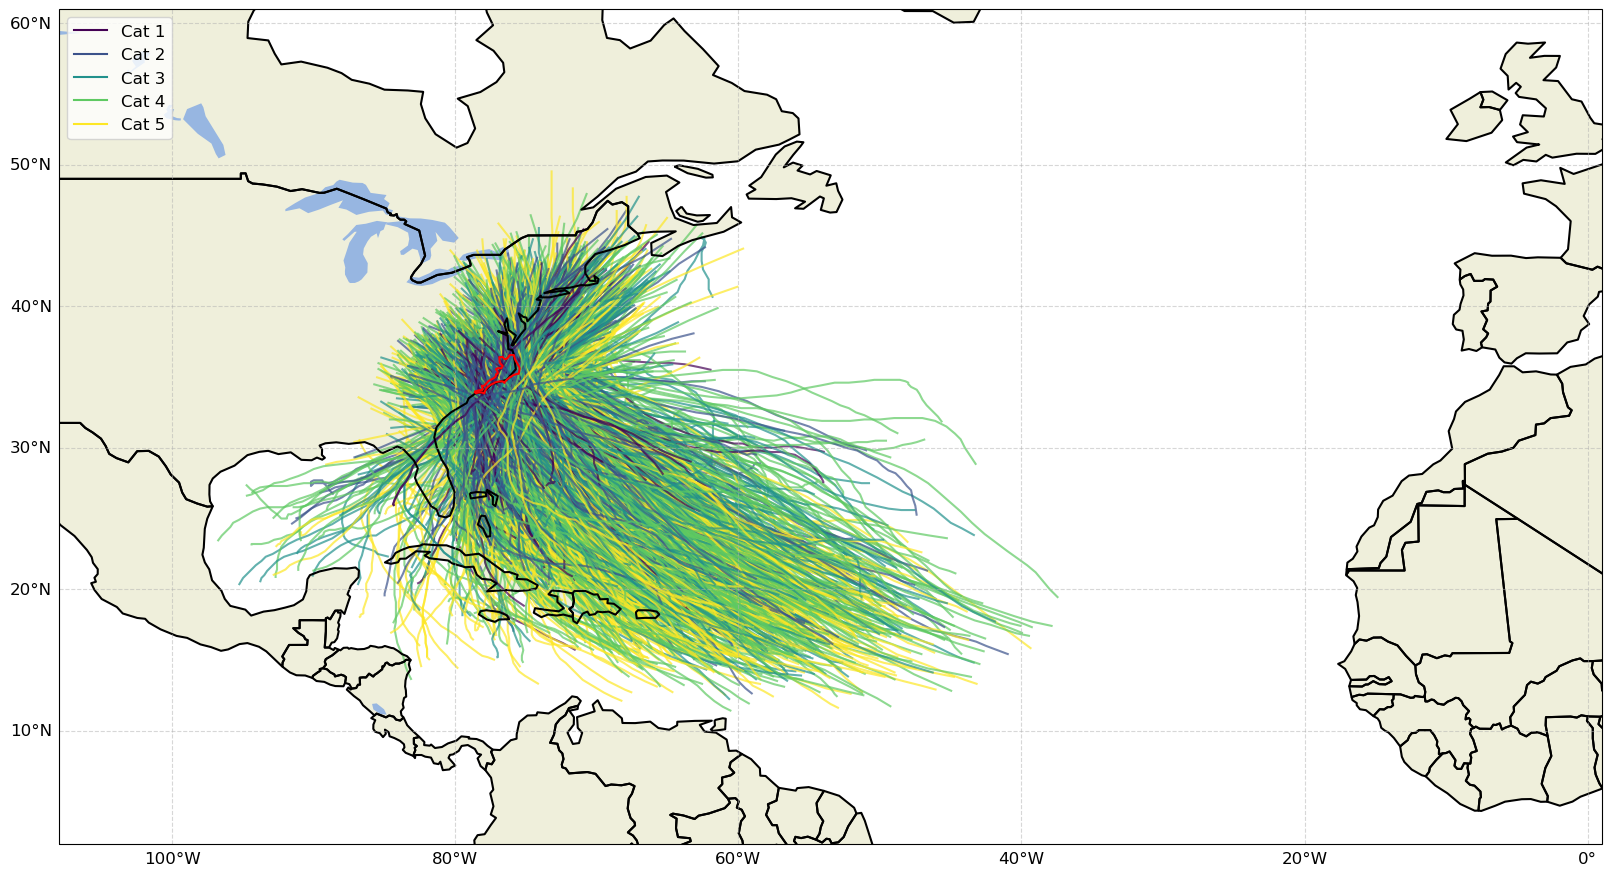

In [8]:
fig, ax = plt.subplots(figsize = (16, 9), subplot_kw={'projection': ccrs.PlateCarree()}, constrained_layout=True)
gdfTracksIn.plot(ax = ax, alpha = 0.7, column = 'max_cat', cmap = 'viridis', legend = True, categorical = True)
dfworld.boundary.plot(ax = ax, color = 'k')
mask.boundary.plot(ax = ax, color = 'r')
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE,lw=0.25)
ax.add_feature(cfeature.LAKES)
ax.set_xlim([-108, 1])
ax.set_ylim([2, 61])
ax.set_aspect('equal')
ax.set_xlabel('Longitude [deg]')
ax.set_ylabel('Latitude [deg]')

legend_elements = [Line2D([0], [0], color=cmap(i/4), label = f'Cat {i+1}') for i in range(5)]
ax.legend(handles=legend_elements, loc = 'upper left')

fig.savefig(f'../documents/thesis/STORM_tracks_IN_batch02.png', dpi = 300, bbox_inches = 'tight')

In [14]:
with plt.rc_context({'font.size': 16}):
    
    # fig, ax = plt.subplots(figsize = (16, 9), subplot_kw={'projection': ccrs.PlateCarree()}, constrained_layout=True)
    # gdftracks.plot(ax = ax, alpha = 0.7, column = 'max_cat', cmap = 'viridis', legend = True, categorical = True)
    # dfworld.boundary.plot(ax = ax, color = 'k')
    # mask.boundary.plot(ax = ax, color = 'r')
    # gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=0.5, linestyle='--')
    # gl.top_labels = False
    # gl.right_labels = False
    # ax.add_feature(cfeature.LAND)
    # # ax.add_feature(cfeature.COASTLINE,lw=10)
    # ax.add_feature(cfeature.LAKES)
    # ax.set_xlim([-108, 1])
    # ax.set_ylim([2, 61])
    # ax.set_aspect('equal')
    # ax.set_xlabel('Longitude [deg]')
    # ax.set_ylabel('Latitude [deg]')


    # legend_elements = [Line2D([0], [0], color=cmap(i/5), label = f'Cat {i}') for i in range(6)]
    # ax.legend(handles=legend_elements, loc = 'upper left')

    # fig.savefig(r'../documents/defense/STORM_alltracks_NA.png', dpi = 300, bbox_inches = 'tight')

    # tc = 61112
    # storm = dftracksFull[dftracksFull['tc_number'] == tc]
    # stormShort = dftracks[dftracks['tc_number'] == tc]


    # fig, ax = plt.subplots(figsize = (16, 9), subplot_kw={'projection': ccrs.PlateCarree()}, constrained_layout=True)
    # dfworld.boundary.plot(ax = ax, color = 'k')
    # mask.boundary.plot(ax = ax, color = 'r')
    # ax.plot(storm['lon'], storm['lat'], color = 'k')

    # aoi = dfaoi.loc[[tc]]
    # norm = colors.BoundaryNorm(np.arange(0, 7, 1), cmap.N)

    # aoi.plot(ax = ax, color = 'r', alpha = 0.2)
    # ax.scatter(storm['lon'].iloc[0], storm['lat'].iloc[0], color = 'r', marker = '*', s = 200)
    # ax.scatter(stormShort['lon'].iloc[0], stormShort['lat'].iloc[0], color = 'k', marker = 'x', s = 500)
    # ax.scatter(stormShort['lon'].iloc[-1], stormShort['lat'].iloc[-1], color = 'k', marker = 'x', s = 500)
    # ax.scatter(storm['lon'], storm['lat'], c = storm['cat'], cmap = cmap, norm = norm, s = 50)

    # gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=0.5, linestyle='--') # show coordinates and grig
    # gl.top_labels = False
    # gl.right_labels = False
    # ax.add_feature(cfeature.LAND)
    # ax.add_feature(cfeature.COASTLINE,lw=0.25)
    # ax.add_feature(cfeature.LAKES)
    # ax.set_xlim([-108, 1])
    # ax.set_ylim([2, 61])
    # ax.set_aspect('equal')
    # ax.set_xlabel('Longitude [deg]')
    # ax.set_ylabel('Latitude [deg]')

    # fig = ax.get_figure()
    # cax = fig.add_axes([0.05, 0.89, 0.15, 0.02])
    # sm = plt.cm.ScalarMappable(cmap = cmap, norm = norm)
    # sm._A = []
    # cb = fig.colorbar(sm, cax = cax, label = 'S - S Wind Scale', orientation = 'horizontal')
    # loc = np.arange(0, 6, 1) + .5
    # cb.set_ticks(loc)
    # cb.set_ticklabels(np.arange(0, 6, 1))

    # fig.savefig(f'../documents/defense/track_storm_{tc}.png', dpi = 300, bbox_inches = 'tight')

    # tc = 54331
    # storm = dftracksFull[dftracksFull['tc_number'] == tc]
    # stormShort = dftracks[dftracks['tc_number'] == tc]


    # fig, ax = plt.subplots(figsize = (16, 9), subplot_kw={'projection': ccrs.PlateCarree()}, constrained_layout=True)
    # dfworld.boundary.plot(ax = ax, color = 'k')
    # mask.boundary.plot(ax = ax, color = 'r')
    # ax.plot(storm['lon'], storm['lat'], color = 'k')

    # aoi = dfaoi.loc[[tc]]
    # norm = colors.BoundaryNorm(np.arange(0, 7, 1), cmap.N)

    # aoi.plot(ax = ax, color = 'r', alpha = 0.2)
    # ax.scatter(storm['lon'].iloc[0], storm['lat'].iloc[0], color = 'r', marker = '*', s = 200)
    # ax.scatter(stormShort['lon'].iloc[0], stormShort['lat'].iloc[0], color = 'k', marker = 'x', s = 500)
    # ax.scatter(stormShort['lon'].iloc[-1], stormShort['lat'].iloc[-1], color = 'k', marker = 'x', s = 500)
    # ax.scatter(storm['lon'], storm['lat'], c = storm['cat'], cmap = cmap, norm = norm, s = 50)


    # gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=0.5, linestyle='--') # show coordinates and grig
    # gl.top_labels = False
    # gl.right_labels = False
    # ax.add_feature(cfeature.LAND)
    # ax.add_feature(cfeature.COASTLINE,lw=0.25)
    # ax.add_feature(cfeature.LAKES)
    # ax.set_xlim([-108, 1])
    # ax.set_ylim([2, 61])
    # ax.set_aspect('equal')
    # ax.set_xlabel('Longitude [deg]')
    # ax.set_ylabel('Latitude [deg]')

    # fig = ax.get_figure()
    # cax = fig.add_axes([0.05, 0.89, 0.15, 0.02])
    # sm = plt.cm.ScalarMappable(cmap = cmap, norm = norm)
    # sm._A = []
    # cb = fig.colorbar(sm, cax = cax, label = 'S - S Wind Scale', orientation = 'horizontal')
    # loc = np.arange(0, 6, 1) + .5
    # cb.set_ticks(loc)
    # cb.set_ticklabels(np.arange(0, 6, 1))

    # fig.savefig(f'../documents/defense/track_storm_{tc}.png', dpi = 300, bbox_inches = 'tight')

    # tc = 20688
    # storm = dftracksFull[dftracksFull['tc_number'] == tc]
    # stormShort = dftracks[dftracks['tc_number'] == tc]


    # fig, ax = plt.subplots(figsize = (16, 9), subplot_kw={'projection': ccrs.PlateCarree()}, constrained_layout=True)
    # dfworld.boundary.plot(ax = ax, color = 'k')
    # mask.boundary.plot(ax = ax, color = 'r')
    # ax.plot(storm['lon'], storm['lat'], color = 'k')

    # aoi = dfaoi.loc[[tc]]
    # norm = colors.BoundaryNorm(np.arange(0, 7, 1), cmap.N)

    # aoi.plot(ax = ax, color = 'r', alpha = 0.2)
    # ax.scatter(storm['lon'].iloc[0], storm['lat'].iloc[0], color = 'r', marker = '*', s = 200)
    # ax.scatter(stormShort['lon'].iloc[0], stormShort['lat'].iloc[0], color = 'k', marker = 'x', s = 500)
    # ax.scatter(stormShort['lon'].iloc[-1], stormShort['lat'].iloc[-1], color = 'k', marker = 'x', s = 500)
    # ax.scatter(storm['lon'], storm['lat'], c = storm['cat'], cmap = cmap, norm = norm, s = 50)

    # gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=0.5, linestyle='--') # show coordinates and grig
    # gl.top_labels = False
    # gl.right_labels = False
    # ax.add_feature(cfeature.LAND)
    # ax.add_feature(cfeature.COASTLINE,lw=0.25)
    # ax.add_feature(cfeature.LAKES)
    # ax.set_xlim([-108, 1])
    # ax.set_ylim([2, 61])
    # ax.set_aspect('equal')
    # ax.set_xlabel('Longitude [deg]')
    # ax.set_ylabel('Latitude [deg]')

    # fig = ax.get_figure()
    # cax = fig.add_axes([0.05, 0.89, 0.15, 0.02])
    # sm = plt.cm.ScalarMappable(cmap = cmap, norm = norm)
    # sm._A = []
    # cb = fig.colorbar(sm, cax = cax, label = 'S - S Wind Scale', orientation = 'horizontal')
    # loc = np.arange(0, 6, 1) + .5
    # cb.set_ticks(loc)
    # cb.set_ticklabels(np.arange(0, 6, 1))

    # fig.savefig(f'../documents/defense/track_storm_{tc}.png', dpi = 300, bbox_inches = 'tight')

    fig, ax = plt.subplots(figsize = (16, 9), subplot_kw={'projection': ccrs.PlateCarree()}, constrained_layout=True)
    gdfTracksIn.plot(ax = ax, alpha = 0.7, column = 'max_cat', cmap = 'viridis', legend = True, categorical = True)
    dfworld.boundary.plot(ax = ax, color = 'k')
    mask.boundary.plot(ax = ax, color = 'r')
    gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.COASTLINE,lw=0.25)
    ax.add_feature(cfeature.LAKES)
    ax.set_xlim([-108, 1])
    ax.set_ylim([2, 61])
    ax.set_aspect('equal')
    ax.set_xlabel('Longitude [deg]')
    ax.set_ylabel('Latitude [deg]')

    legend_elements = [Line2D([0], [0], color=cmap(i/4), label = f'Cat {i+1}') for i in range(5)]
    ax.legend(handles=legend_elements, loc = 'upper left')

    # fig.savefig(r'../documents/waves_and_storm_surge/STORM_tracks_IN_batch02.png', dpi = 300, bbox_inches = 'tight')
    fig.savefig(f'../documents/defense/STORM_tracks_IN_batch02.png', dpi = 300, bbox_inches = 'tight')

In [12]:
gdfTracksIn.describe().T

count          mean           std   min       25%      50%  \
tc_number  1814.0  54259.888093  31667.141187  66.0  27200.25  53189.5   
run_index  1814.0    906.500000    523.801012   0.0    453.25    906.5   
max_cat    1814.0      3.535281      1.189966   1.0      3.00      4.0   
lon_gen    1814.0    -65.878942      9.890068 -96.8    -73.60    -66.1   
lat_gen    1814.0     21.760970      4.795403  11.4     17.90     21.3   

                75%       max  
tc_number  82418.00  109436.0  
run_index   1359.75    1813.0  
max_cat        4.00       5.0  
lon_gen      -58.70     -37.4  
lat_gen       25.40      40.6

In [11]:
len(gdfTracksIn)

1814

In [12]:
gdfTracksIn.describe().T

count          mean           std   min       25%      50%  \
tc_number  1814.0  54259.888093  31667.141187  66.0  27200.25  53189.5   
run_index  1814.0    906.500000    523.801012   0.0    453.25    906.5   
max_cat    1814.0      3.535281      1.189966   1.0      3.00      4.0   
lon_gen    1814.0    -65.878942      9.890068 -96.8    -73.60    -66.1   
lat_gen    1814.0     21.760970      4.795403  11.4     17.90     21.3   

                75%       max  
tc_number  82418.00  109436.0  
run_index   1359.75    1813.0  
max_cat        4.00       5.0  
lon_gen      -58.70     -37.4  
lat_gen       25.40      40.6

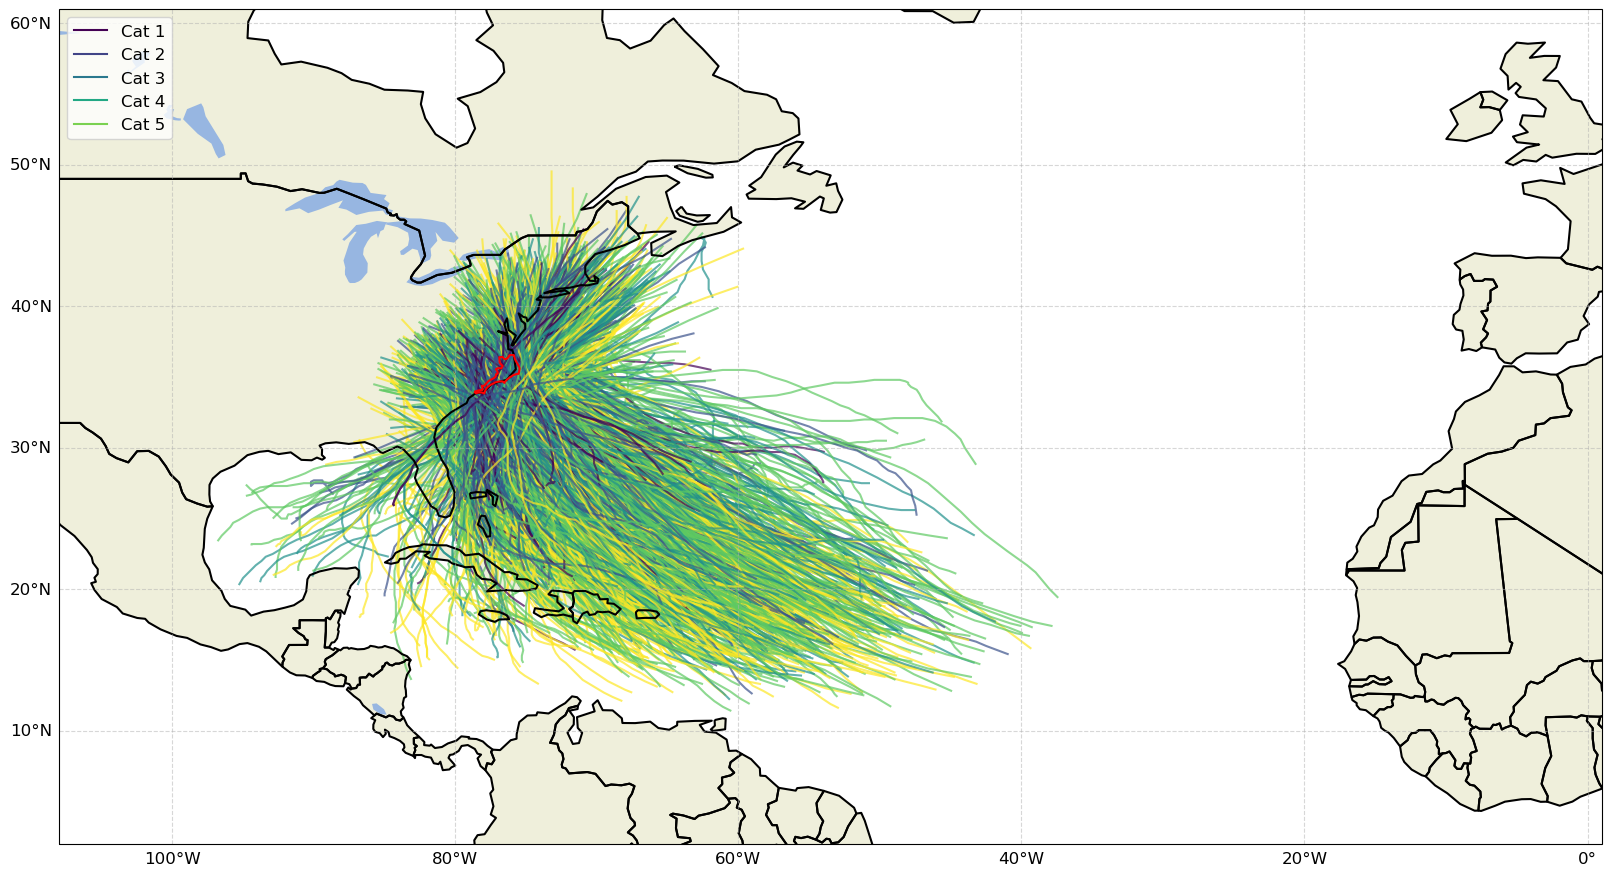

In [142]:
gdfTracksIn.head()

tc_number  run_index  max_cat  lon_gen  lat_gen  \
0      20688          0      4.0    -57.2     18.4   
1       7120          1      4.0    -65.1     23.2   
2      44019          2      4.0    -60.7     22.2   
3      85333          3      4.0    -72.1     26.2   
4      31573          4      4.0    -74.9     27.1   

                                            geometry  
0  LINESTRING (-57.20000 18.40000, -57.70000 18.8...  
1  LINESTRING (-65.10000 23.20000, -65.60000 23.8...  
2  LINESTRING (-60.70000 22.20000, -61.20000 22.5...  
3  LINESTRING (-72.10000 26.20000, -72.10000 26.7...  
4  LINESTRING (-74.90000 27.10000, -74.40000 27.4...

In [14]:
# lab = [f'Storm {sid:0.0f}: {x:03d} pnts' for sid, x in zip(dfcl['tc_number'][:10], dfcl['npoints'][:10])]
lab = [f'Storm {sid:0.0f}' for sid, x in zip(dfcl['tc_number'][:10], dfcl['npoints'][:10])]

fig, ax = plt.subplots(figsize = (20, 20))
ax.plot([-76.8], [35.2], color = 'k', marker = '*')

legend_elements = []
cm = plt.colormaps.get('tab10')
for ig, g in enumerate(dfcl['tc_number'][:10]):
    gdf[gdf['tc_number'] == g].plot(ax = ax, legend = True, color = cm(ig/9))
    legend_elements.append(Line2D([0], [0], color=cm(ig/9), label = f'Storm {ig}'))
    ax.scatter([gdf[gdf['tc_number'] == g].geometry.iloc[0].coords[0][0]],
                [gdf[gdf['tc_number'] == g].geometry.iloc[0].coords[0][1]], color = cm(ig/9), label = '_nolegend_')
dfworld.plot(ax = ax, color = 'silver', alpha = 0.5)
dfworld.boundary.plot(ax = ax, color = 'k')
mask.boundary.plot(ax = ax, color = 'k', ls = '--')

ax.set_xlim([-110, 10])
ax.set_ylim([0, 65])
ax.set_aspect('equal')
ax.set_xlabel('Longitude [deg]')
ax.set_ylabel('Latitude [deg]')
# ax.set_title('10 most dissimilar storms selected')

ax.legend(handles=legend_elements, title = 'Diss. Index:')
# fig.savefig(r'/mnt/drive1/GoogleDrive/NCSU/NCSU/courses/CE610/project2/10most_dissimilar.png', dpi = 300, bbox_inches = 'tight')
# fig.savefig(r'../documents/adcircMeeting/10most_dissimilar.png', dpi = 300, bbox_inches = 'tight')
# text = AnchoredText(nb_name, 'upper right',frameon = False, borderpad = -2, prop=dict(fontsize = 'xx-small', alpha = 0.4))
# ax.add_artist(text)

fig.savefig(f'../documents/thesis/10most_dissimilar.png', dpi = 300, bbox_inches = 'tight')

NameError: name 'dfcl' is not defined

In [147]:
gdfTracksIn.head()

tc_number  run_index  max_cat  lon_gen  lat_gen  \
0      20688          0      4.0    -57.2     18.4   
1       7120          1      4.0    -65.1     23.2   
2      44019          2      4.0    -60.7     22.2   
3      85333          3      4.0    -72.1     26.2   
4      31573          4      4.0    -74.9     27.1   

                                            geometry  
0  LINESTRING (-57.20000 18.40000, -57.70000 18.8...  
1  LINESTRING (-65.10000 23.20000, -65.60000 23.8...  
2  LINESTRING (-60.70000 22.20000, -61.20000 22.5...  
3  LINESTRING (-72.10000 26.20000, -72.10000 26.7...  
4  LINESTRING (-74.90000 27.10000, -74.40000 27.4...

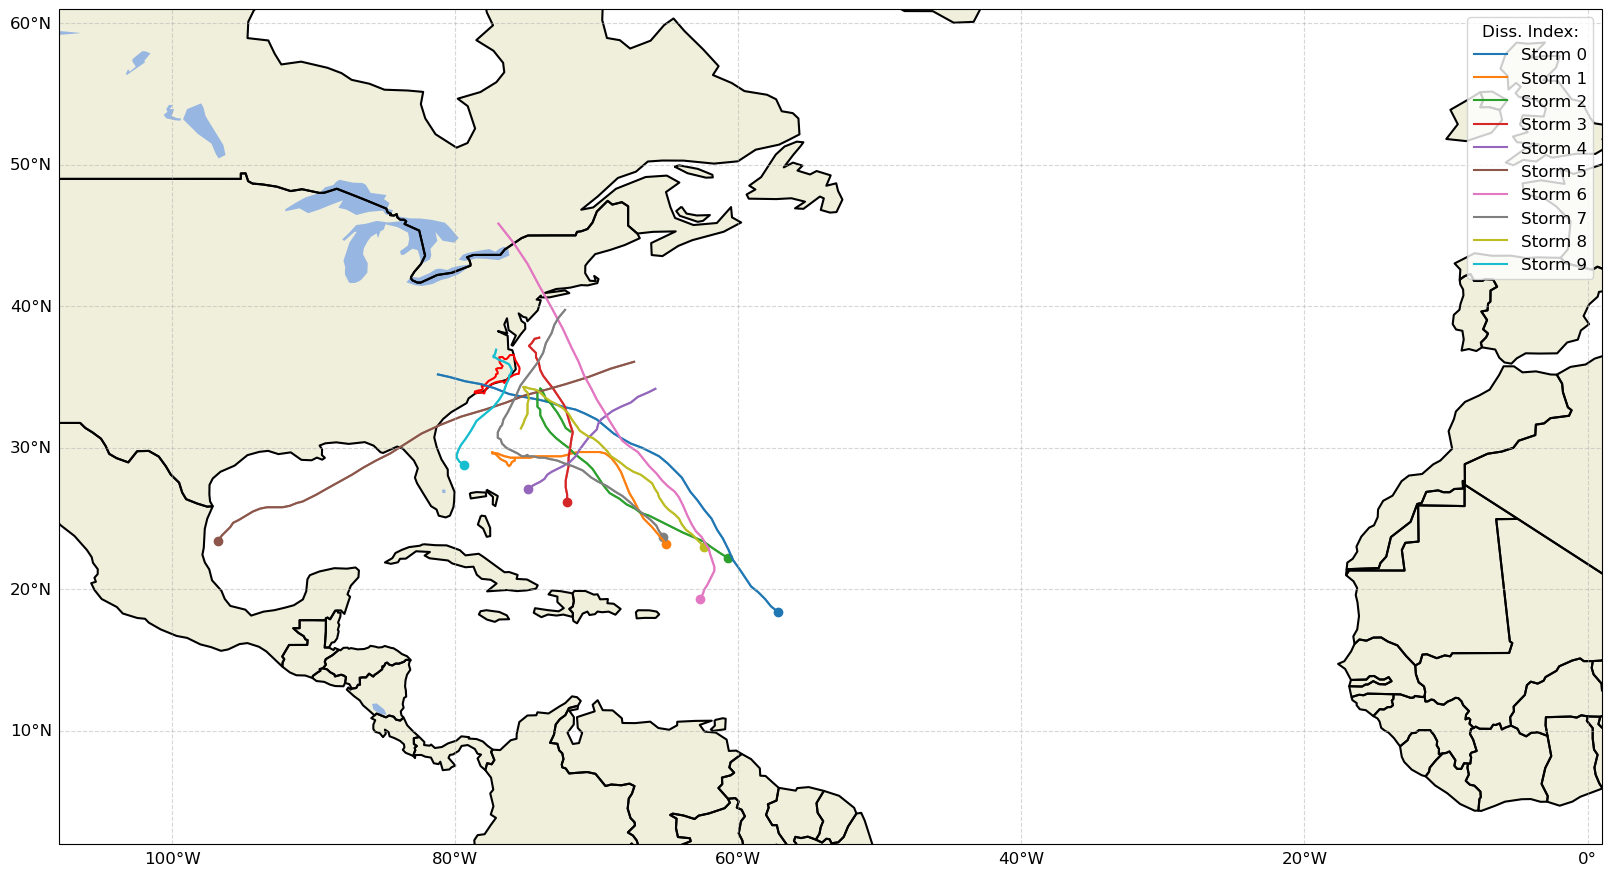

In [15]:
fig, ax = plt.subplots(figsize = (16, 9), subplot_kw={'projection': ccrs.PlateCarree()}, constrained_layout=True)
dfworld.boundary.plot(ax = ax, color = 'k')
gdfTracksIn.iloc[:10, :].plot(ax = ax, alpha = 0.7, column = 'run_index', cmap = 'tab10', legend = True, categorical = True)
mask.boundary.plot(ax = ax, color = 'r')
# mask.plot(ax = ax, color = 'r')

legend_elements = []
cm = plt.colormaps.get('tab10')
for i in range(10):
    gdfTracksIn[gdfTracksIn['run_index'] == i].plot(ax = ax, legend = True, color = cm(i/9))
    legend_elements.append(Line2D([0], [0], color=cm(i/9), label = f'Storm {i}'))
    ax.scatter([gdfTracksIn[gdfTracksIn['run_index'] == i].geometry.iloc[0].coords[0][0]],
                [gdfTracksIn[gdfTracksIn['run_index'] == i].geometry.iloc[0].coords[0][1]], 
                color = cm(i/9), label = '_nolegend_')



gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE,lw=0.25)
ax.add_feature(cfeature.LAKES)
ax.set_xlim([-108, 1])
ax.set_ylim([2, 61])
ax.set_aspect('equal')
ax.set_xlabel('Longitude [deg]')
ax.set_ylabel('Latitude [deg]')
ax.legend(handles=legend_elements, title = 'Diss. Index:')

# legend_elements = [Line2D([0], [0], color=cmap(i/5), label = f'Cat {i}') for i in range(6)]
# ax.legend(handles=legend_elements, loc = 'upper left')
#
# fig.savefig(r'../documents/waves_and_storm_surge/STORM_tracks_10most_diss.png', dpi = 300, bbox_inches = 'tight')
fig.savefig(f'../documents/thesis/STORM_tracks_10most_diss.png', dpi = 300, bbox_inches = 'tight')

In [3]:
dfr = pd.read_pickle(r'../data/STORM/processed/batch02/STORM_NA_R5_In_v3_pnt_inpMDA_minCat1.pkl')

In [8]:
dfpnt = pd.read_pickle(r"../data/STORM/processed/batch02/STORM_NA_R5_In_v3_pnt.pkl")

In [50]:
len(dfpnt)

3626

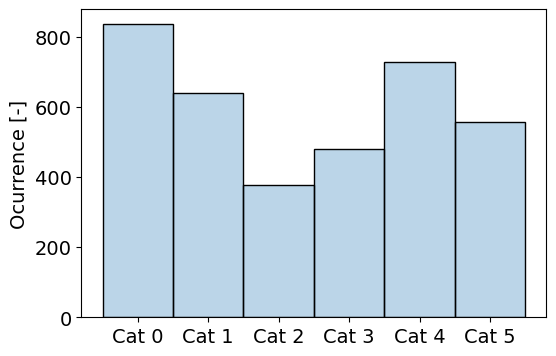

In [71]:
fig, ax = plt.subplots(figsize = (6, 4))
sns.histplot(dfpnt['max_cat'].astype(int), ax = ax, alpha = 0.3, edgecolor = 'k', kde = False, bins = np.arange(0, 7))
ax.set_xticks(np.arange(0.5, 6.5, 1))
ax.set_xticklabels([f'Cat {x}' for x in range(0, 6)])
ax.set_xlabel('')
ax.set_ylabel('Ocurrence [-]')
fig.savefig(f'../documents/thesis/distribution_cat_impactful_storms.png', dpi = 300, bbox_inches = 'tight')

(array([838., 641., 378., 482., 729., 558.,   0.]),
 array([0., 1., 2., 3., 4., 5., 6., 7.]),
 <BarContainer object of 7 artists>)

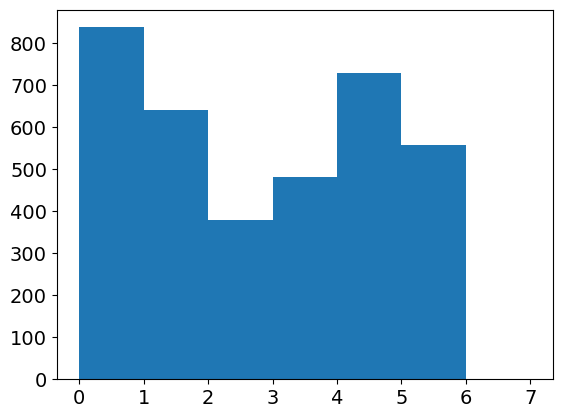

In [74]:
plt.hist(dfpnt['max_cat'].astype(int), bins = np.arange(0, 8))

In [75]:
auxScale = [ssScale(dfpnt.loc[i, 'max_ws_at_min_distNC']) for i in dfpnt.index]
dfpnt['cat_at_min_distNC'] = auxScale

(array([1792.,  773.,  438.,  468.,  153.,    2.]),
 array([0., 1., 2., 3., 4., 5., 6.]),
 <BarContainer object of 6 artists>)

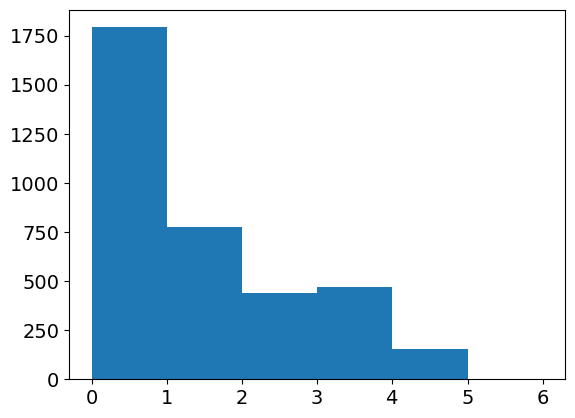

In [77]:
plt.hist(dfpnt['cat_at_min_distNC'].astype(int), bins = np.arange(0, 7))

In [99]:
dfr['duration'].sum()*3

883395

In [97]:
89.188097/24

3.7161707083333333

In [90]:
d1 = dfpnt[dfpnt['duration'] > 24]

In [92]:
d1[d1['cat_at_min_distNC'] > 0]

year  month  yr_tc_number  time_step_at_min_press  \
1        6.0    9.0          10.0                    34.0   
2       12.0    9.0           2.0                    43.0   
5       30.0    9.0          11.0                    11.0   
6       31.0    9.0           9.0                    19.0   
7       34.0    9.0           5.0                     8.0   
...      ...    ...           ...                     ...   
3612  9974.0    8.0           1.0                    42.0   
3617  9982.0    9.0           3.0                    33.0   
3618  9982.0    9.0          14.0                    15.0   
3620  9985.0    9.0           7.0                    19.0   
3622  9996.0    9.0           9.0                    28.0   

      time_step_at_min_distNC  lat_at_min_press  lon_at_min_press  \
1                        49.0              22.6             -75.9   
2                        63.0              28.0             -65.8   
5                        28.0              22.4             -78.0   
6                        64.0              16.2             -50.4   
7                        21.0              25.8             -78.4   
...                       ...               ...               ...   
3612                     63.0              25.7             -57.4   
3617                     35.0              34.2             -74.3   
3618                     14.0              34.2             -79.6   
3620                     22.0              31.6             -76.2   
3622                     27.0              33.6             -79.2   

      lat_at_min_distNC  lon_at_min_distNC  min_press_at_min_distNC  ...  \
1                  34.1              -78.6                    931.6  ...   
2                  35.4              -75.2                    963.1  ...   
5                  35.5              -74.8                    978.1  ...   
6                  35.1              -76.9                    968.3  ...   
7                  34.1              -78.4                    974.7  ...   
...                 ...                ...                      ...  ...   
3612               37.4              -75.5                    968.9  ...   
3617               34.7              -76.1                    977.6  ...   
3618               33.7              -78.7                    977.4  ...   
3620               33.8              -78.8                    964.8  ...   
3622               33.2              -78.1                    956.0  ...   

      distNC_at_min_press  heading_dir_at_min_distNC  \
1             1269.069372                 355.236358   
2             1252.456827                 353.659808   
5             1274.475622                  14.036243   
6             3299.856108                 318.814075   
7              898.720827                  26.565051   
...                   ...                        ...   
3612          2061.816788                 311.633539   
3617           191.210919                 285.255119   
3618           151.428700                 299.054604   
3620           305.789772                 311.633539   
3622           116.057099                 289.983107   

      heading_dir_at_min_press  duration  lat_gen  lon_gen        length  \
1                   326.309932       162     13.4    -58.8  4.107373e+06   
2                   308.659808       210      8.6    -45.7  5.071078e+06   
5                     0.000000       102     18.8    -75.1  2.833629e+06   
6                   315.000000       207     12.3    -38.4  5.218927e+06   
7                   341.565051        81     23.6    -75.7  1.619152e+06   
...                        ...       ...      ...      ...           ...   
3612                306.869898       207      7.1    -29.4  6.431779e+06   
3617                277.125016       123     27.1    -53.6  2.889740e+06   
3618                302.005383        60     27.7    -66.5  1.828596e+06   
3620                307.874984        81     23.1    -61.7  2.562404e+06   
3622                288.

In [89]:
d1[d1['duration'] < 24]

Empty DataFrame
Columns: [year, month, yr_tc_number, time_step_at_min_press, time_step_at_min_distNC, lat_at_min_press, lon_at_min_press, lat_at_min_distNC, lon_at_min_distNC, min_press_at_min_distNC, min_press_at_min_press, max_ws_at_min_distNC, max_ws_at_min_press, rad_to_max_ws_at_min_distNC, rad_to_max_ws_at_min_press, forward_speed_at_min_distNC, forward_speed_at_min_press, max_cat, landfall, tc_number, distNC_at_min_distNC, distNC_at_min_press, heading_dir_at_min_distNC, heading_dir_at_min_press, duration, lat_gen, lon_gen, length, mean_heading_dir_inter, mean_curvature_inter, cat_at_min_distNC]
Index: []

[0 rows x 31 columns]

In [86]:
dfpnt[dfpnt['duration'] < 24]

year  month  yr_tc_number  time_step_at_min_press  \
12      46.0   10.0           6.0                     2.0   
28      87.0    8.0           9.0                     2.0   
89     261.0    8.0           1.0                     2.0   
96     270.0    7.0           2.0                     2.0   
107    288.0    8.0           4.0                     2.0   
...      ...    ...           ...                     ...   
3573  9893.0    9.0           8.0                     2.0   
3574  9893.0    9.0           8.0                     2.0   
3615  9979.0    7.0           0.0                     2.0   
3621  9987.0   10.0           8.0                     2.0   
3624  9997.0   10.0           5.0                     4.0   

      time_step_at_min_distNC  lat_at_min_press  lon_at_min_press  \
12                        1.0              33.5             -75.1   
28                        0.0              37.4             -75.6   
89                        1.0              37.1             -77.0   
96                        1.0              34.4             -78.1   
107                       0.0              32.2             -77.2   
...                       ...               ...               ...   
3573                      3.0              34.0             -76.4   
3574                      3.0              34.0             -76.4   
3615                      3.0              34.7             -74.8   
3621                      3.0              34.6             -75.8   
3624                      4.0              35.6             -75.1   

      lat_at_min_distNC  lon_at_min_distNC  min_press_at_min_distNC  ...  \
12                 33.3              -75.8              1001.900000  ...   
28                 35.4              -75.9               999.186140  ...   
89                 36.4              -76.2               998.300000  ...   
96                 34.0              -77.9               996.400000  ...   
107                33.6              -77.6               999.097261  ...   
...                 ...                ...                      ...  ...   
3573               34.2              -76.8               999.200000  ...   
3574               34.2              -76.8               999.200000  ...   
3615               35.3              -74.9              1000.500000  ...   
3621               35.2              -75.4              1000.400000  ...   
3624               35.6              -75.1               998.900000  ...   

      distNC_at_min_press  heading_dir_at_min_distNC  \
12             185.487397                  74.054604   
28             103.391456                   5.710593   
89             118.617972                 311.185925   
96              56.224037                 333.434949   
107            202.803321                 164.054604   
...                   ...                        ...   
3573            78.193252                 300.963757   
3574            78.193252                 300.963757   
3615           119.808136                 350.537678   
3621            65.124266                  32.005383   
3624            67.275253                  29.744881   

      heading_dir_at_min_press  duration  lat_gen  lon_gen         length  \
12                   68.198591        15     33.0    -76.4  242038.454860   
28                   16.699244        18     35.4    -75.9  536056.972188   
89                  320.194429        15     35.7    -75.5  367596.173667   
96                    0.000000        21     33.6    -77.6  280959.280623   
107                 146.309932        15     33.6    -77.6  294678.380119   
...                        ...       ...      ...      ...            ...   
3573                296.565051        15     33.7    -75.6  181665.967446   
3574                296.565051        18     33.7    -75.6  237843.113468   
3615                350.537678        12     33.4    -74.5  214432.354930   
3621                 33.690068        18     33.4    -76.4  433219.373750   
3624         

In [101]:
162/24

6.75

In [27]:
dfhists = dfpnt[dfpnt['tc_number'].isin(dfr.index)]

In [32]:
from concorde.tools import ssScale

In [36]:
auxScale = [ssScale(dfhists.loc[i, 'max_ws_at_min_distNC']) for i in dfhists.index]
dfhists['cat_at_min_distNC'] = auxScale

In [107]:
dfhists[['max_ws_at_min_press', 'max_ws_at_min_distNC']].describe()

max_ws_at_min_press  max_ws_at_min_distNC
count          1814.000000            1814.00000
mean             53.739252              45.66409
std              10.325459               8.22405
min              32.900000              33.00000
25%              45.400000              38.90000
50%              54.350000              44.80000
75%              62.000000              51.30000
max              83.502870              83.50287

In [131]:
dummy = dfhists[['max_ws_at_min_press', 'max_ws_at_min_distNC']]

In [143]:
len(dfhists[dfhists['landfall'] == 0])/len(dfhists)

0.04575523704520397

In [135]:
dummy1 = dfhists[['min_press_at_min_press', 'min_press_at_min_distNC']]

In [136]:
dummy1.describe()

min_press_at_min_press  min_press_at_min_distNC
count             1814.000000              1814.000000
mean               941.444377               956.767310
std                 19.944154                15.242113
min                883.400000               883.400000
25%                924.800000               946.800000
50%                941.800000               959.100000
75%                958.100000               969.400000
max                983.800000               983.900000

In [138]:
dummy1[dummy1 < 884].dropna()

min_press_at_min_press  min_press_at_min_distNC
2080                   883.4                    883.4

In [122]:
dfhists.loc[[2080], 'tc_number']

2080    61112.0
Name: tc_number, dtype: float64

In [119]:
dfpnt[dfpnt['tc_number'] == 61112]['run_index']

KeyError: 'run_index'

In [120]:
dfpnt.columns

Index(['year', 'month', 'yr_tc_number', 'time_step_at_min_press',
       'time_step_at_min_distNC', 'lat_at_min_press', 'lon_at_min_press',
       'lat_at_min_distNC', 'lon_at_min_distNC', 'min_press_at_min_distNC',
       'min_press_at_min_press', 'max_ws_at_min_distNC', 'max_ws_at_min_press',
       'rad_to_max_ws_at_min_distNC', 'rad_to_max_ws_at_min_press',
       'forward_speed_at_min_distNC', 'forward_speed_at_min_press', 'max_cat',
       'landfall', 'tc_number', 'distNC_at_min_distNC', 'distNC_at_min_press',
       'heading_dir_at_min_distNC', 'heading_dir_at_min_press', 'duration',
       'lat_gen', 'lon_gen', 'length', 'mean_heading_dir_inter',
       'mean_curvature_inter', 'cat_at_min_distNC'],
      dtype='object')

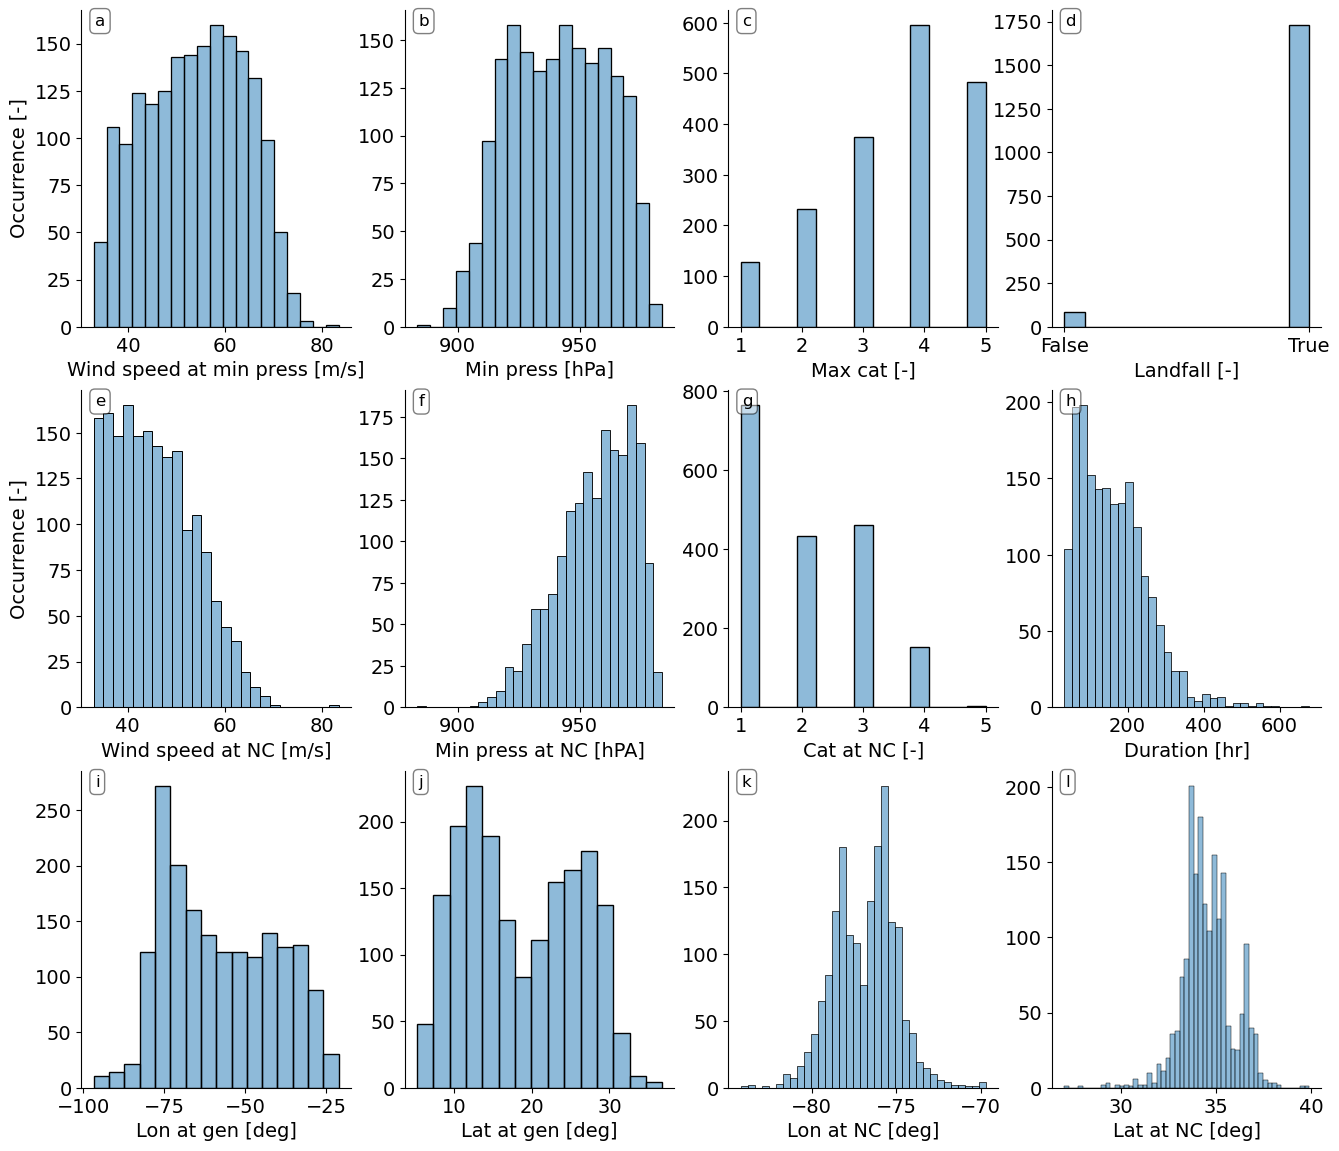

In [104]:
cols = ['max_ws_at_min_press', 'min_press_at_min_press', 'max_cat', 'landfall', 
        'max_ws_at_min_distNC', 'min_press_at_min_distNC', 'cat_at_min_distNC', 'duration',
        'lon_gen', 'lat_gen', 'lon_at_min_distNC', 'lat_at_min_distNC']
xlabs = ['Wind speed at min press [m/s]', 'Min press [hPa]', 'Max cat [-]', 'Landfall [-]', 
         'Wind speed at NC [m/s]', 'Min press at NC [hPA]', 'Cat at NC [-]', 'Duration [hr]', 
         'Lon at gen [deg]', 'Lat at gen [deg]', 'Lon at NC [deg]', 'Lat at NC [deg]']

props = dict(boxstyle='round', facecolor='white', alpha=0.5)

plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(figsize = (16, 14), nrows = 3, ncols = 4)
for icol, col in enumerate(cols):
    axs = ax.flatten()[icol]
    sns.histplot(dfhists[col], ax = axs, alpha = 0.5)
    axs.set_ylabel('')
    axs.set_xlabel(xlabs[icol])
    axs.spines[['right', 'top']].set_visible(False)
    axs.text(0.05, 0.95, string.ascii_lowercase[icol], transform=axs.transAxes, fontsize=12, bbox=props)

    # anchored_text = AnchoredText(string.ascii_lowercase[icol], loc=2, borderpad=0.,frameon=True, alpha = 0.5)
    # axs.add_artist(anchored_text, alpha = 0.1)

# text = AnchoredText(nb_name, 'upper right',frameon = False, borderpad = -2, prop=dict(fontsize = 'xx-small', alpha = 0.4))
# ax[0, 3].add_artist(text)
# ax[2, 3].spines[['right', 'top', 'left', 'bottom']].set_visible(False)
ax[0, 3].set_xticks([0, 1])
ax[0, 3].set_xticklabels(['False', 'True'])
ax[0, 2].set_xticks(np.arange(1, 6, 1))
ax[1, 2].set_xticks(np.arange(1, 6, 1))
ax[0, 3].set_xticklabels(['False', 'True'])
# ax[2, 3].axis('off')
ax[0, 0].set_ylabel('Occurrence [-]')
ax[1, 0].set_ylabel('Occurrence [-]')
# fig.savefig(r'/mnt/drive1/Insyncs/NCSU/courses/CE610/project2/distribution_inp_mda_batch02.png', dpi = 300, bbox_inches = 'tight')
fig.savefig(f'../documents/thesis/distribution_inp_mda_batch02_r2.png', dpi = 300, bbox_inches = 'tight')

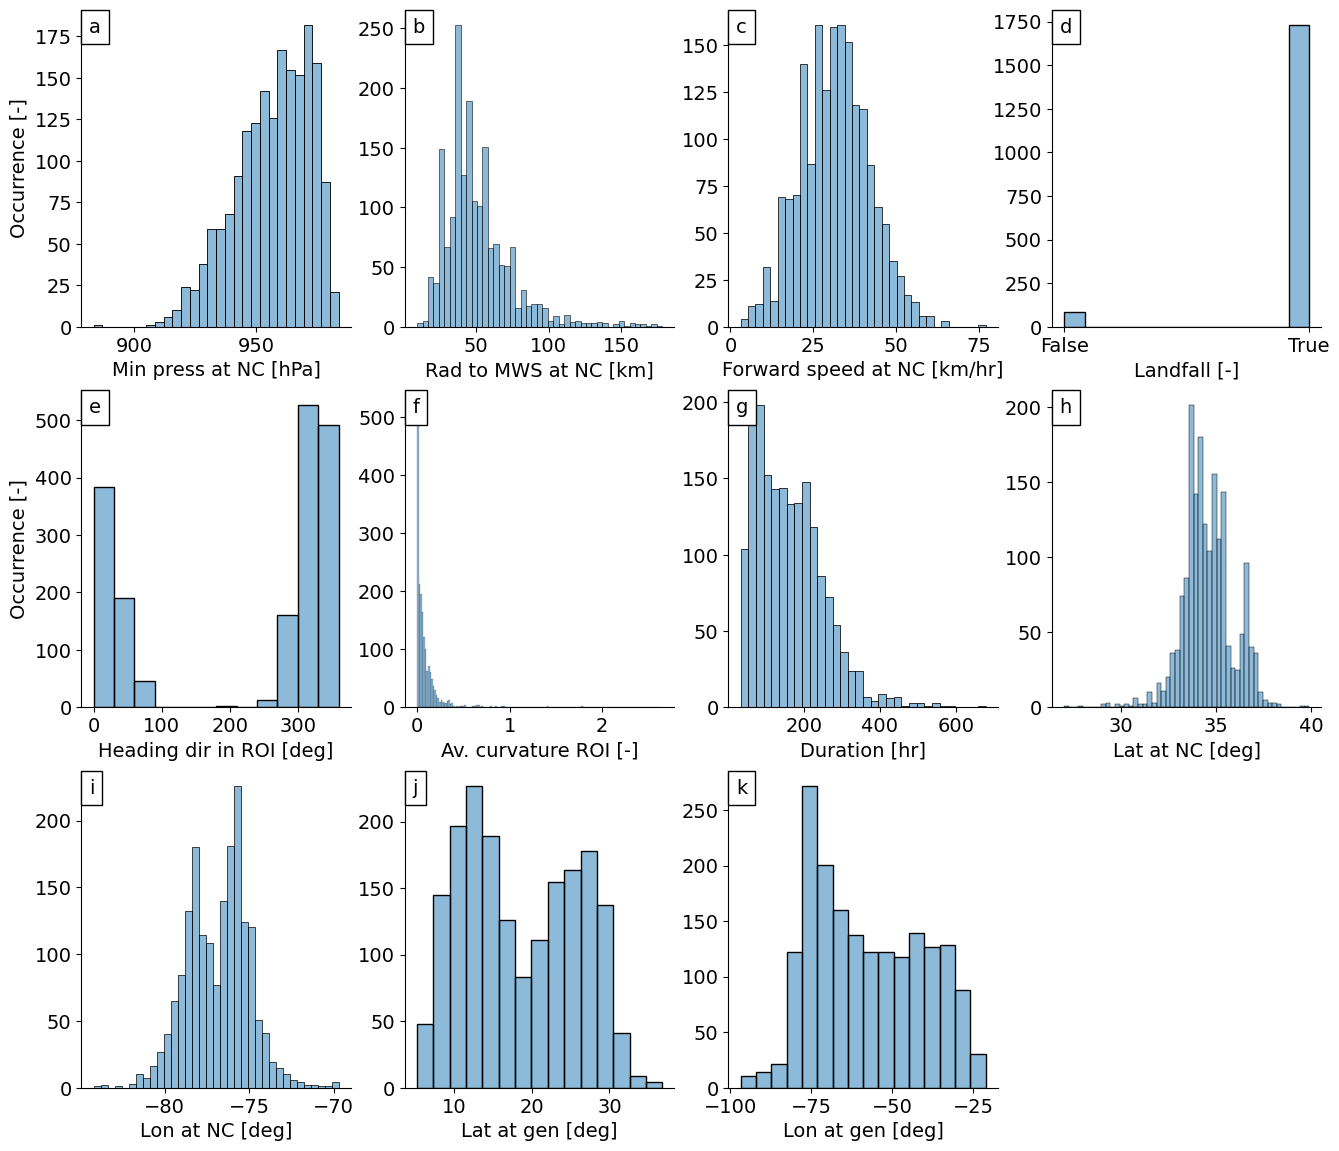

In [6]:
cols = ['min_press_at_min_distNC', 'rad_to_max_ws_at_min_distNC', 'forward_speed_at_min_distNC', 'landfall', 'mean_heading_dir_inter', 'mean_curvature_inter', 'duration', 'lat_at_min_distNC', 'lon_at_min_distNC', 'lat_gen', 'lon_gen']
xlabs = ['Min press at NC [hPa]', 'Rad to MWS at NC [km]', 'Forward speed at NC [km/hr]', 'Landfall [-]', 'Heading dir in ROI [deg]', 'Av. curvature ROI [-]', 'Duration [hr]', 'Lat at NC [deg]', 'Lon at NC [deg]', 'Lat at gen [deg]', 'Lon at gen [deg]']

plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(figsize = (16, 14), nrows = 3, ncols = 4)
for icol, col in enumerate(cols):
    axs = ax.flatten()[icol]
    sns.histplot(dfr[col], ax = axs, alpha = 0.5)
    axs.set_ylabel('')
    axs.set_xlabel(xlabs[icol])
    axs.spines[['right', 'top']].set_visible(False)

    anchored_text = AnchoredText(string.ascii_lowercase[icol], loc=2,borderpad=0.,frameon=True, alpha = 0.5)
    axs.add_artist(anchored_text)

# text = AnchoredText(nb_name, 'upper right',frameon = False, borderpad = -2, prop=dict(fontsize = 'xx-small', alpha = 0.4))
# ax[0, 3].add_artist(text)
# ax[2, 3].spines[['right', 'top', 'left', 'bottom']].set_visible(False)
ax[0, 3].set_xticks([0, 1])
ax[0, 3].set_xticklabels(['False', 'True'])
ax[2, 3].axis('off')
ax[0, 0].set_ylabel('Occurrence [-]')
ax[1, 0].set_ylabel('Occurrence [-]')
# fig.savefig(r'/mnt/drive1/Insyncs/NCSU/courses/CE610/project2/distribution_inp_mda_batch02.png', dpi = 300, bbox_inches = 'tight')
fig.savefig(f'../documents/thesis/distribution_inp_mda_batch02.png', dpi = 300, bbox_inches = 'tight')

In [102]:
dfr['duration'].sum()*3

883395